## Setup

In [78]:
import os

from dataclasses import asdict
from pathlib import Path
from typing import List, Tuple

import torch
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib.colors import to_rgba
from scipy.stats import bootstrap
from transformers.hf_argparser import HfArgumentParser

from procyon.data.it_data_config import (
    expand_datasets_on_splits,
    ITMultiDatasetConfig,
)
from procyon.evaluate.framework.args import EvalArgs
from procyon.evaluate.framework.utils import (
    load_and_validate_model_args,
    override_data_and_model_args,
)
from procyon.training.training_args_IT import (
    DataArgs,
    ModelArgs,
    update_data_args_data_dir,
)

In [2]:
base_path = Path("/n/home08/rcalef/sandbox/projects/txplm/canonical_evals/")

our_model_name = "ProCyon"
zero_shot_name = "ProCyon (zero shot)"

# Load benchmarking results

In [3]:
retrieval_dirs = {
    base_path / "eval_new_splits": ["ProCyon"],
    base_path / "new_split_evals" / "zero_shot_baselines": ["BioTranslator", "ProtST"],
    base_path / "new_split_evals" / "simple_baselines": [
        "BlastKnn",
        "ESM3Knn",
        "ESM3MLP",
        "ESMKnn",
        "ESMMLP",
        "GearNetKnn",
        "GearNetMLP",
        "MajorityRule",
        "UniformRandom",
        "WeightedRandom",
    ],
}

retrieval_dir_by_model = {
    model: path for path, models in retrieval_dirs.items() for model in models
}

qa_dirs = {
    base_path / "eval_new_splits": ["ProCyon"],
    base_path / "new_split_evals" / "simple_baselines": [
        "BlastKnn",
        "ESM3Knn",
        "ESM3MLP",
        "ESMKnn",
        "ESMMLP",
        "GearNetKnn",
        "GearNetMLP",
    ],
}


qa_dir_by_model = {
    model: path for path, models in qa_dirs.items() for model in models
}

zero_shot_models = [
    "ProCyon",
    "BioTranslator",
    "ProtST",
]

In [4]:
# Use ProCyon evals to get datasets
config_yml = retrieval_dir_by_model["ProCyon"] / "args.yml"
parser = HfArgumentParser((EvalArgs, DataArgs, ModelArgs))
eval_args, data_args, model_args = parser.parse_yaml_file(config_yml)

separate_splits = True
keep_splits_union = False

# Check if we want to override ModelArgs using a ProCyon checkpoint
if eval_args.model_args_from_checkpoint != "":
    checkpoint_dir = eval_args.model_args_from_checkpoint
    print(f"Loading ModelArgs from ProCyon checkpoint: {checkpoint_dir}")
    model_args = torch.load(os.path.join(checkpoint_dir, "model_args.pt"))
    model_args = ModelArgs(**asdict(model_args))

if eval_args.data_args_from_checkpoint != "":
    checkpoint_dir = eval_args.data_args_from_checkpoint
    print(f"Loading DataArgs from ProCyon checkpoint: {checkpoint_dir}")
    loaded_data_args = torch.load(os.path.join(checkpoint_dir, "data_args.pt"))
    loaded_data_args = DataArgs(**asdict(loaded_data_args))

    update_data_args_data_dir(loaded_data_args)

    # Prefer to use the data config specified in data_args passed into this function
    # over one specified in the serialized data config.
    if data_args.it_data_config_yml is not None:
        loaded_data_args.it_data_config_yml = data_args.it_data_config_yml
    data_args = loaded_data_args

# Check if we want to override any of the DataArgs or ModelArgs values parsed
# from the model checkpoint.
if eval_args.override_model_data_args_yml is not None:
    override_data_and_model_args(
        data_args, model_args, eval_args.override_model_data_args_yml
    )

# Parse model specifications.
models = load_and_validate_model_args(eval_args.models_config_yml)

config = ITMultiDatasetConfig.load_from_yaml(data_args.it_data_config_yml)
if separate_splits:
    config.testing_datasets = expand_datasets_on_splits(
        config.testing_datasets, keep_splits_union
    )

Loading ModelArgs from ProCyon checkpoint: /n/holylfs06/LABS/mzitnik_lab/Lab/PLM/huggingface_repos/ProCyon-Split
Loading DataArgs from ProCyon checkpoint: /n/holylfs06/LABS/mzitnik_lab/Lab/PLM/huggingface_repos/ProCyon-Split
updating data args DATA_DIR from /n/holystore01/LABS/mzitnik_lab/Lab/PLM/ -> /n/holylfs06/LABS/mzitnik_lab/Lab/PLM/huggingface_repos/ProCyon-Instruct


In [5]:
func_task = "Protein function"
comp_task = "Cellular component"
path_task = "Biological pathway"
targ_task = "Drug target"
dpi_task = "Drug-protein interaction"
dis_task = "Disease association"
ec_task = "EC number"
dom_task = "Protein domains"

task_order = [
    func_task,
    comp_task,
    path_task,
    ec_task,
    targ_task,
    dpi_task,
    dis_task,
    #dom_task,
]

task_map = {
    'protein_go:process': func_task,
    'protein_go:function': func_task,
    'protein_reactome:all': path_task,
    'protein_go:component': comp_task,
    'protein_drugbank:drug_target': targ_task,
    'protein_drugbank:drug_enzyme': dpi_task,
    'protein_drugbank:drug_carrier': dpi_task,
    'protein_drugbank:drug_transporter':  dpi_task,
    'protein_disgenet:all': dis_task,
    'protein_omim:all': dis_task,
    'protein_ec:all': ec_task,
    'domain_pfam:all': dom_task,
    'domain_go:process': dom_task,
    'domain_go:function': dom_task,
    'domain_go:component': dom_task
}

In [6]:
_split_maps = {
    "pt_ft": ["pt_ft"],
    "few_shot": ["few_shot", "zero_shot_easy", "zero_shot"],
    "zero_shot": ["zero_shot_hard"],
}
split_maps = {
    x : k for k, v in _split_maps.items() for x in v
}

def map_split(x):
    return split_maps.get(x, "few_shot")

_split_maps_old = {
    "pt_ft": ["pt_ft"],
    "few_shot": ["few_shot"],
    "zero_shot": ["zero_shot", "zero_shot_hard"],
}
split_maps_old = {
    x : k for k, v in _split_maps_old.items() for x in v
}

def map_split_old(x):
    return split_maps_old.get(x, "few_shot")

def parse_dataset_string(s: str) -> Tuple[str, str, str]:
    aaseq, text, oth = s.split("_", maxsplit=2)
    if "eval" in oth:
        relation, split = [x.strip("_").rstrip("_") for x in oth.split("eval")]
        if split not in ["pt_ft", "zero_shot", "zero_shot_easy", "zero_shot_hard"]:
            split = "few_shot"
    else:
        relation = oth
        split = "all"
    return aaseq + "_" + text, relation, split


def get_per_text_retrieval_results(model: str, key: str) -> pd.DataFrame:
    path = retrieval_dir_by_model[model] / "retrieval" / model/ key / "per_text_metrics.tsv"
    return pd.read_table(path)

def get_qa_results(model: str, key: str) -> pd.DataFrame:
    path = qa_dir_by_model[model] / "qa" / model/ key / "results_dict.pkl"
    return pd.DataFrame(pd.read_pickle(path))

def load_and_map(
    model: str,
    orig_key: str,
    benchmark_task: str = "retrieval",
) -> pd.DataFrame:
    dataset, relation, split = parse_dataset_string(orig_key)
    mapped_split = map_split(split)

    dataset_relation = dataset + ":" + relation
    task = task_map[dataset_relation]

    if benchmark_task == "retrieval":
        results = (
            get_per_text_retrieval_results(model, orig_key)
            .drop(columns=["sample_num"])
            .groupby("query_id")
            .mean()
            .reset_index()
        )
    elif benchmark_task == "qa":
        results = (
            get_qa_results(model, orig_key)
            .assign(
                correct=lambda x: x.pred == x.y,
            )
            .drop(columns=["pred", "y"])
        )
    else:
        raise ValueError(f"unknown task: {benchmark_task}")

    return (
        results
        .assign(
            dataset_relation=dataset_relation,
            dataset=dataset,
            orig_split=split,
            orig_plot_split=map_split_old(split),
            plot_split=mapped_split,
            plot_task=task,
        )
    )

In [7]:
all_results = []
for dset in config.testing_datasets:
    for relation in dset.relations:
        dset_key = dset._construct_key(relation)
        for model in retrieval_dir_by_model.keys():
            if "zero_shot" in dset_key and model not in zero_shot_models:
                continue
            all_results.append(
                load_and_map(model, dset_key)
                .assign(model=model)
            )

all_results = pd.concat(all_results)
print(all_results.shape)
all_results.head()

(94846, 17)


,query_id,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,auprc,dataset_relation,dataset,orig_split,orig_plot_split,plot_split,plot_task,model
0,0,0.30,0.750000,0.170000,0.85,0.090909,1.0,0.732857,0.881875,0.652682,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
1,1,0.20,1.000000,0.100000,1.00,0.090909,1.0,1.000000,1.000000,1.000000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
2,5,0.20,1.000000,0.100000,1.00,0.090909,1.0,0.603175,0.887500,0.512143,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
3,8,0.22,0.733333,0.150000,1.00,0.090909,1.0,0.667619,0.881111,0.577133,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
4,9,0.10,1.000000,0.090909,1.00,0.090909,1.0,0.866667,0.970000,0.800000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon


In [8]:
all_qa_results = []
for dset in config.testing_datasets:
    for relation in dset.relations:
        dset_key = dset._construct_key(relation)
        for model in qa_dir_by_model.keys():
            if "zero_shot" in dset_key and model not in zero_shot_models:
                continue
            all_qa_results.append(
                load_and_map(model, dset_key, benchmark_task="qa")
                .assign(model=model)
            )

all_qa_results = (
    pd.concat(all_qa_results)
    .drop(columns=["seq_ids", "text_ids"])
)
print(all_qa_results.shape)
all_qa_results.head()

(952442, 8)


,correct,dataset_relation,dataset,orig_split,orig_plot_split,plot_split,plot_task,model
0,True,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
1,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
2,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
3,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
4,True,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon


In [9]:
alpha = 1
procyon_color = "#9467BD"

model_colors = {
    "BLAST-kNN": to_rgba("dodgerblue", alpha),
    "ESM3-MLP": to_rgba("deepskyblue", alpha),
    "GearNet-MLP": to_rgba("darkblue", alpha),
    "BioTranslator": to_rgba("firebrick", alpha),
    "ProtST": to_rgba("salmon", alpha),
    "ProtLLM": to_rgba("red", alpha),
    our_model_name: procyon_color,
    zero_shot_name: procyon_color,
}

def calc_error_bounds(vals):
    rng = np.random.default_rng(seed=42)

    res = bootstrap(
        (vals,),
        statistic=np.mean,
        confidence_level=0.95,
        n_resamples=9999,
        batch=10000,
        random_state=rng,
        paired=False,
    )
    return (res.confidence_interval.low,res.confidence_interval.high)

# Check new splits

In [10]:
split_rename = {
    "pt_ft": "Text frequently\nseen in training",
    "few_shot": "Text rarely\nseen in training",
    "zero_shot": "Text never\nseen in training",
}
split_order = list(split_rename.values())

In [11]:
def split_comparison_plot(
    plot_data: pd.DataFrame,
    metric: str,
):
    fg = sns.FacetGrid(
        data=plot_data,
        row="plot_task",
        col="split_groups",
        margin_titles=False,
        col_order=["Old", "New"],
    )

    fg.map_dataframe(
        sns.barplot,
        x="plot_split",
        y=metric,
        order=split_order,
        edgecolor="black",
        errorbar=None,
    )
    # Set column titles only for the first row
    for col_idx, col_name in enumerate(fg.col_names):
        fg.axes[0, col_idx].set_title(f"{col_name} splits", fontsize=16, y=1.15, fontweight="normal")

    # Remove column titles for all other rows
    for i in range(1, len(fg.row_names)):
        for j in range(len(fg.col_names)):
            fg.axes[i, j].set_title("")

    # Add subtitles for each row
    for i, row_val in enumerate(fg.row_names):

        ax = fg.axes[i, 0]  # Get leftmost axis for this row
        ax.annotate(
            row_val,
            xy=(1.1, 1.05),  # Above the top of the row
            xycoords="axes fraction",
            ha="center",
            va="bottom",
            fontsize=14,
            fontweight="normal"
        )

    bottom_row_idx = len(fg.row_names) - 1  # Index of last row
    for ax in fg.axes[bottom_row_idx, :]:
        for label in ax.get_xticklabels():
            label.set_rotation(45)  # Rotate labels 45 degrees
            label.set_ha("right")

    fg.set_axis_labels(x_var="Phenotype group")

    for (task, split_type), ax in fg.axes_dict.items():
        counts = (
            plot_data
            .query("split_groups == @split_type and plot_task == @task")
            .plot_split.value_counts()
            [split_order]
        )
        ax.bar_label(ax.containers[0], labels=counts, padding=3, fontsize=12, label_type="center")

        rects = [x for x in ax.containers[0]]
        rects = sorted(rects, key=lambda x: x.get_x())

        x_coords = []
        y_coords = []
        yerr = []
        for rect, split in zip(rects, split_order):
            want_df = plot_data.query("split_groups == @split_type and plot_task == @task and plot_split == @split")
            err_lb, err_ub = calc_error_bounds(want_df[metric].values)

            xval = rect.get_center()[0]
            yval = rect.get_height()

            x_coords.append(xval)
            y_coords.append(yval)
            yerr.append(np.abs((err_lb - yval, err_ub - yval)))

            # Add text above the bar
            ax.text(
                x=xval,
                y=err_ub,
                s=f"{yval:.2f}",
                ha="center",
                va="bottom",
                fontsize=12,
            )

        yerr = np.array(yerr).T
        ax.errorbar(
            x=x_coords,
            y=y_coords,
            yerr=yerr,
            fmt="none",
            c="k",
            alpha=0.8,
            elinewidth=2,
        )

## Retrieval

In [12]:
procyon_data = all_results.query("model == 'ProCyon'")
plot_data = (
    pd.concat((
        procyon_data[["Fmax", "plot_task", "plot_split"]].assign(split_groups="new"),
        (procyon_data[["Fmax", "plot_task", "orig_plot_split"]]
        .rename(columns={"orig_plot_split": "plot_split"})
        .assign(split_groups="old")),
    ))
    .assign(
        plot_split=lambda x: x.plot_split.map(split_rename),
        split_groups=lambda x: x.split_groups.str.title(),
    )
)
plot_data.head()

,Fmax,plot_task,plot_split,split_groups
0,0.732857,Protein function,Text frequently\nseen in training,New
1,1.000000,Protein function,Text frequently\nseen in training,New
2,0.603175,Protein function,Text frequently\nseen in training,New
3,0.667619,Protein function,Text frequently\nseen in training,New
4,0.866667,Protein function,Text frequently\nseen in training,New


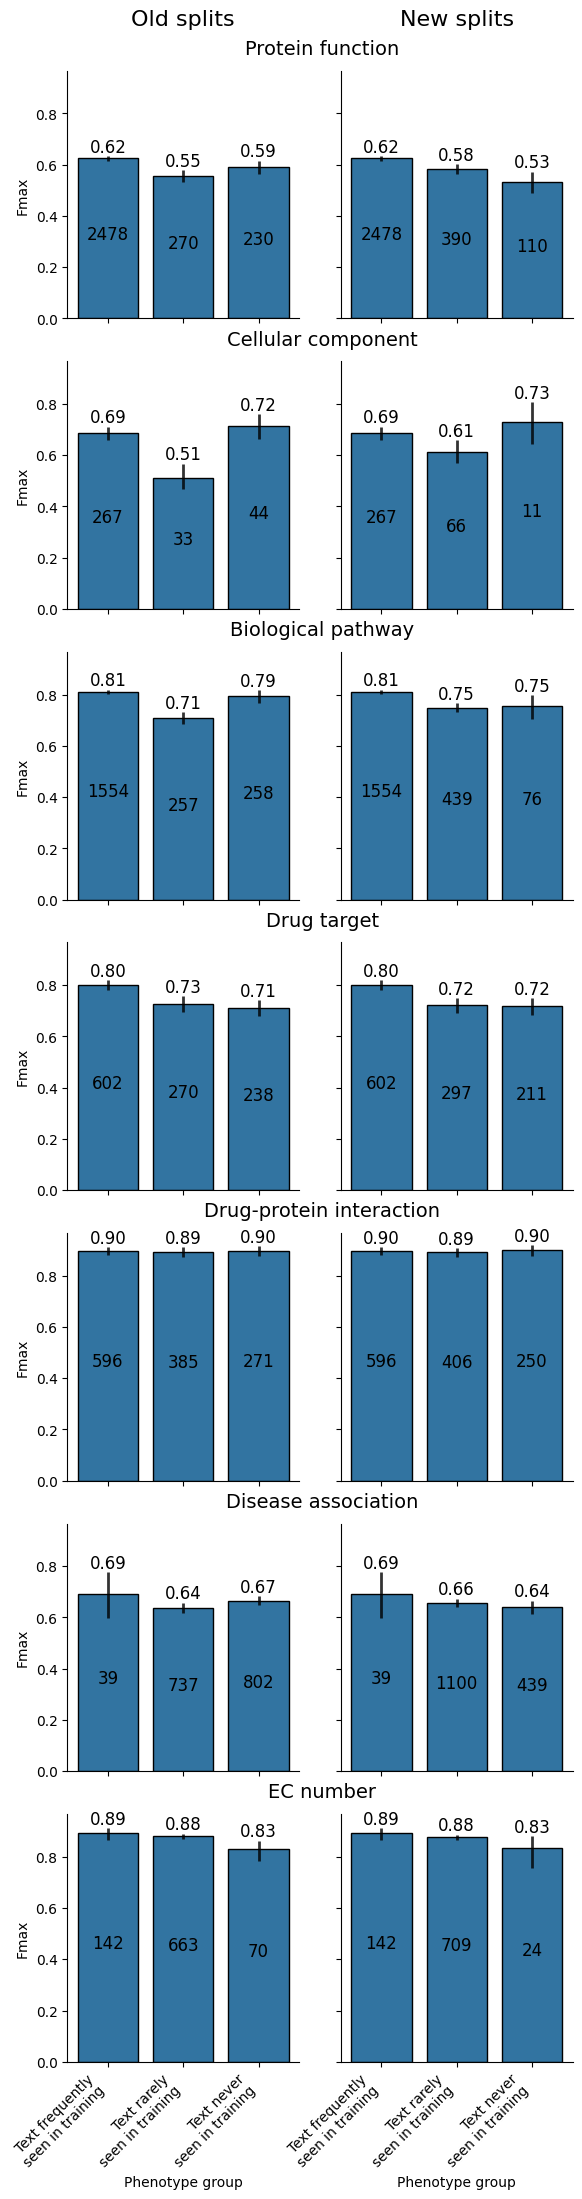

In [13]:
split_comparison_plot(plot_data, "Fmax")

## QA

In [14]:
procyon_data = all_qa_results.query("model == 'ProCyon'")
plot_data = (
    pd.concat((
        procyon_data[["correct", "plot_task", "plot_split"]].assign(split_groups="new"),
        (procyon_data[["correct", "plot_task", "orig_plot_split"]]
        .rename(columns={"orig_plot_split": "plot_split"})
        .assign(split_groups="old")),
    ))
    .assign(
        plot_split=lambda x: x.plot_split.map(split_rename),
        split_groups=lambda x: x.split_groups.str.title(),
    )
)
plot_data.head()

,correct,plot_task,plot_split,split_groups
0,True,Protein function,Text frequently\nseen in training,New
1,False,Protein function,Text frequently\nseen in training,New
2,False,Protein function,Text frequently\nseen in training,New
3,False,Protein function,Text frequently\nseen in training,New
4,True,Protein function,Text frequently\nseen in training,New


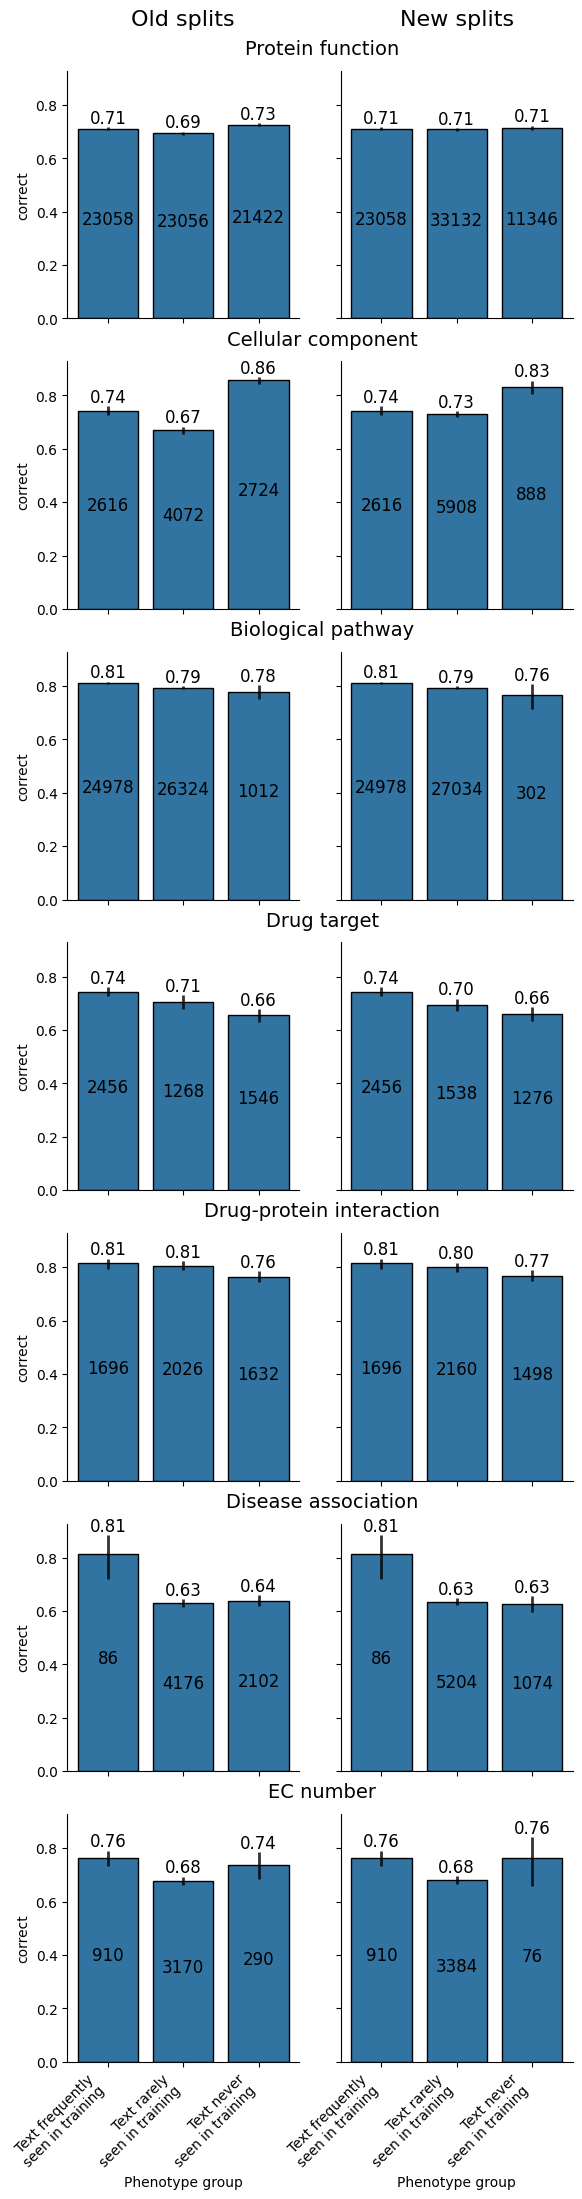

In [15]:
split_comparison_plot(plot_data, "correct")

# Benchmarking plots

In [16]:
retrieval_benchmark_results = all_results.copy()
retrieval_benchmark_results.loc[lambda x: (x.model == our_model_name) & (x.plot_split == "zero_shot"), "model"] = zero_shot_name

qa_benchmark_results = all_qa_results.copy()
qa_benchmark_results.loc[lambda x: (x.model == our_model_name) & (x.plot_split == "zero_shot"), "model"] = zero_shot_name

_split_maps_benchmarking = {
    "pt_ft": ["pt_ft"],
    "few_shot": ["few_shot"],
    "zero_shot": ["zero_shot_hard"],
}
split_maps_benchmarking = {
    x : k for k, v in _split_maps_benchmarking.items() for x in v
}

def map_split_benchmarking(x):
    return split_maps_benchmarking.get(x, "few_shot")

In [17]:
def annotated_bar_plot(
    plot_data: pd.DataFrame,
    model_order: List[str],
    metric: str,
    static_colors: bool=True,
    textsize: float = 12,
    height: float = 5,
    fontscale: float = 2,
):
    sns.set_theme(context="paper", style="ticks", font_scale=fontscale)
    sns.set_style("ticks")
    fg = sns.FacetGrid(
        data=plot_data,
        col="plot_task",
        col_wrap=4,
        height=height,
        aspect=1,
        margin_titles=True,
    )
    if static_colors:
        palette = {model: model_colors[model] for model in model_order}
    else:
        oth_models = [x for x in model_order if our_model_name not in x]
        palette = {x: color for x, color in zip(oth_models,sns.color_palette())}
        palette[our_model_name] = procyon_color
        palette[zero_shot_name] = procyon_color

    fg.map_dataframe(
        sns.barplot,
        x="model",
        y=metric,
        order=model_order,
        edgecolor="black",
        hue="model",
        palette=palette,
        data=plot_data,
        errorbar=None,
    )

    fg.set_titles(template="{col_name}")
    fg.set_xlabels("")
    if metric == "Fmax":
        ylabel = "Retrieval $F_{\max}$"
    elif metric == "correct":
        ylabel = "QA Accuracy"
    else:
        ylabel = metric
    fg.set_ylabels(ylabel)

    for ax in fg.axes:
        if len(ax.get_xticklabels()) == 0:
            continue
        for label in ax.get_xticklabels():
            label.set(rotation=45, rotation_mode="anchor", ha="right")

    for task, ax in fg.axes_dict.items():
        rects = [x[0] for x in ax.containers]
        rects = sorted(rects, key=lambda x: x.get_x())

        x_coords = []
        y_coords = []
        yerr = []

        procyon_x_coords = []
        procyon_y_coords = []
        procyon_yerr = []
        for rect, model in zip(rects, model_order):
            want_df = plot_data.query("plot_task == @task and model == @model")
            err_lb, err_ub = calc_error_bounds(want_df[metric].values)

            xval = rect.get_center()[0]
            yval = rect.get_height()

            if our_model_name not in model:
                rect.set(alpha=0.3)
                x_coords.append(xval)
                y_coords.append(yval)
                yerr.append(np.abs((err_lb - yval, err_ub - yval)))
            else:
                procyon_x_coords.append(xval)
                procyon_y_coords.append(yval)
                procyon_yerr.append(np.abs((err_lb - yval, err_ub - yval)))

            if model == zero_shot_name:
                rect.set(hatch="xx")

            # Add text above the bar
            ax.text(
                x=xval,
                y=err_ub,
                s=f"{yval:.2f}",
                ha="center",
                va="bottom",
                fontsize=textsize,
            )

        yerr = np.array(yerr).T
        ax.errorbar(
            x=x_coords,
            y=y_coords,
            yerr=yerr,
            fmt="none",
            c="k",
            alpha=0.5,
            elinewidth=2,
        )

        procyon_yerr = np.array(procyon_yerr).T
        ax.errorbar(
            x=procyon_x_coords,
            y=procyon_y_coords,
            yerr=procyon_yerr,
            fmt="none",
            c="k",
            alpha=0.9,
            elinewidth=2,
        )

In [18]:
def annotated_bar_plot_horizontal(
    plot_data: pd.DataFrame,
    model_order: List[str],
    metric: str,
    static_colors: bool=True,
    textsize: float = 12,
    height: float = 5,
    fontscale: float = 2,
):
    sns.set_theme(context="paper", style="ticks", font_scale=fontscale)
    sns.set_style("ticks")
    fg = sns.FacetGrid(
        data=plot_data,
        col="plot_task",
        col_wrap=4,
        height=height,
        aspect=1,
        margin_titles=True,
    )
    if static_colors:
        palette = {model: model_colors[model] for model in model_order}
    else:
        oth_models = [x for x in model_order if our_model_name not in x]
        palette = {x: color for x, color in zip(oth_models,sns.color_palette())}
        palette[our_model_name] = procyon_color
        palette[zero_shot_name] = procyon_color

    fg.map_dataframe(
        sns.barplot,
        x=metric,
        y="model",
        order=model_order,
        edgecolor="black",
        hue="model",
        palette=palette,
        data=plot_data,
        errorbar=None,
    )

    fg.set_titles(template="{col_name}")
    fg.set_ylabels("")
    if metric == "Fmax":
        xlabel = "Retrieval $F_{\max}$"
    elif metric == "correct":
        xlabel = "QA Accuracy"
    else:
        xlabel = metric
    fg.set_xlabels(xlabel)

    for task, ax in fg.axes_dict.items():
        rects = [x[0] for x in ax.containers]
        rects = sorted(rects, key=lambda x: x.get_y())

        x_coords = []
        y_coords = []
        yerr = []

        procyon_x_coords = []
        procyon_y_coords = []
        procyon_yerr = []
        for rect, model in zip(rects, model_order):
            want_df = plot_data.query("plot_task == @task and model == @model")
            err_lb, err_ub = calc_error_bounds(want_df[metric].values)

            yval = rect.get_center()[1]
            xval = rect.get_width()

            if our_model_name not in model:
                rect.set(alpha=0.3)
                x_coords.append(xval)
                y_coords.append(yval)
                yerr.append(np.abs((err_lb - xval, err_ub - xval)))
            else:
                procyon_x_coords.append(xval)
                procyon_y_coords.append(yval)
                procyon_yerr.append(np.abs((err_lb - xval, err_ub - xval)))

            if model == zero_shot_name:
                rect.set(hatch="xx")

            # Add text above the bar
            ax.text(
                x=err_ub + 0.01,
                y=yval,
                s=f"{xval:.2f}",
                ha="left",
                va="center",
                fontsize=textsize,
            )

        yerr = np.array(yerr).T
        ax.errorbar(
            x=x_coords,
            y=y_coords,
            xerr=yerr,
            fmt="none",
            c="k",
            alpha=0.5,
            elinewidth=2,
        )

        procyon_yerr = np.array(procyon_yerr).T
        ax.errorbar(
            x=procyon_x_coords,
            y=procyon_y_coords,
            xerr=procyon_yerr,
            fmt="none",
            c="k",
            alpha=0.9,
            elinewidth=2,
        )

## Retrieval

In [19]:
# We need different split maps here since most of the baselines
# can't handle the zero-shot phenotypes that we're treating as few-shot now.
retrieval_data = (
    retrieval_benchmark_results
    .loc[lambda x: ~x.orig_split.isin(["zero_shot_easy", "zero_shot"])]
    .loc[lambda x: (x.plot_split != "zero_shot") | (x.model == zero_shot_name)]
)
retrieval_data.model.value_counts()


model
ProCyon                6658
BioTranslator          6658
ProtST                 6658
MajorityRule           6658
WeightedRandom         6658
UniformRandom          6658
ESM3MLP                6322
ESM3Knn                6322
BlastKnn               6322
ESMKnn                 6322
GearNetMLP             6322
GearNetKnn             6322
ESMMLP                 6322
ProCyon (zero shot)    1121
Name: count, dtype: int64

In [20]:
main_fig_models = {
    "BlastKnn": "BLAST-kNN",
    "ESM3MLP": "ESM3-MLP",
    "GearNetMLP": "GearNet-MLP",
    "BioTranslator": "BioTranslator",
    "ProtST": "ProtST",
    "ProCyon": "ProCyon",
}

model_order = list(main_fig_models.values())

In [21]:
plot_data = (
    retrieval_data
    .loc[lambda x: x.model.isin(main_fig_models)]
    .assign(model=lambda x: x.model.map(main_fig_models))
    .reset_index(drop=True)
)
plot_data.head()

,query_id,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,auprc,dataset_relation,dataset,orig_split,orig_plot_split,plot_split,plot_task,model
0,0,0.30,0.750000,0.170000,0.85,0.090909,1.0,0.732857,0.881875,0.652682,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
1,1,0.20,1.000000,0.100000,1.00,0.090909,1.0,1.000000,1.000000,1.000000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
2,5,0.20,1.000000,0.100000,1.00,0.090909,1.0,0.603175,0.887500,0.512143,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
3,8,0.22,0.733333,0.150000,1.00,0.090909,1.0,0.667619,0.881111,0.577133,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
4,9,0.10,1.000000,0.090909,1.00,0.090909,1.0,0.866667,0.970000,0.800000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon


In [22]:
#TODO: why do ProCyon, BioTranslator, and ProtST have more here?
plot_data.model.value_counts()

model
ProCyon          6658
BioTranslator    6658
ProtST           6658
BLAST-kNN        6322
ESM3-MLP         6322
GearNet-MLP      6322
Name: count, dtype: int64

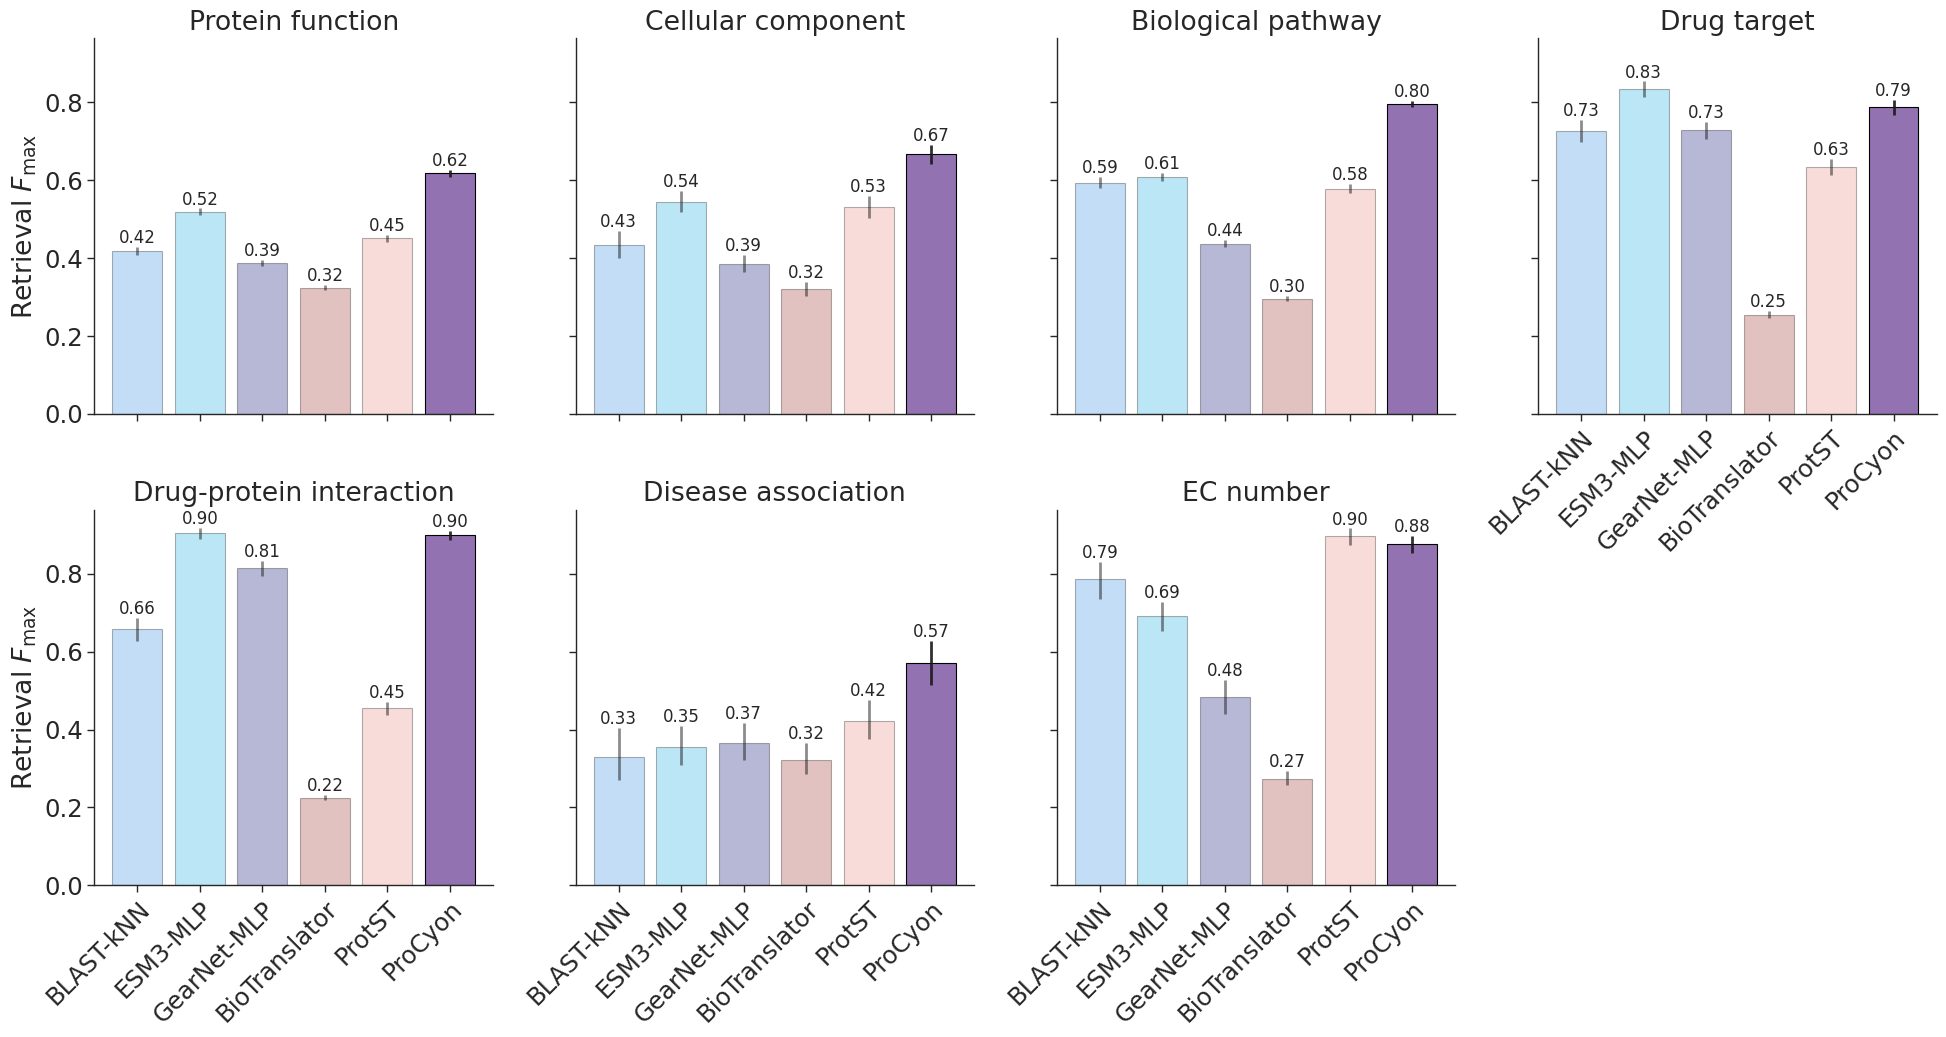

In [23]:
annotated_bar_plot(
    plot_data,
    model_order=model_order,
    metric="Fmax",
    textsize=12.
)

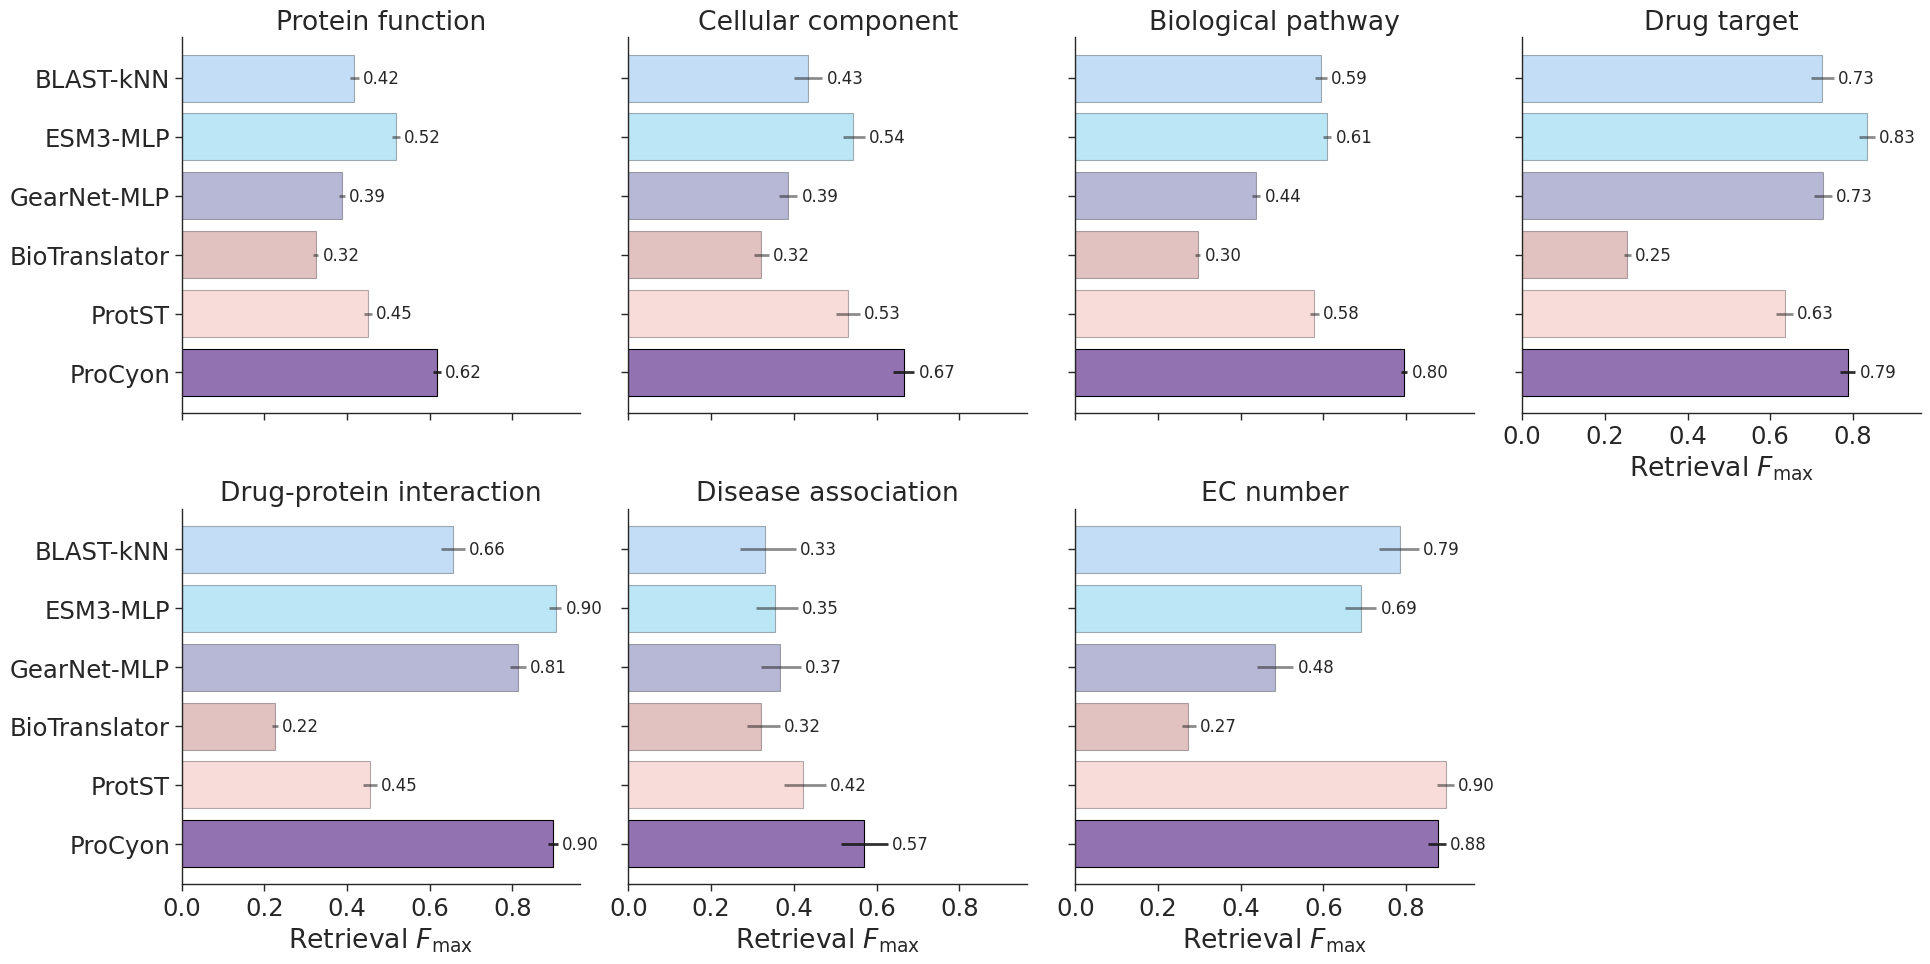

In [24]:
annotated_bar_plot_horizontal(
    plot_data,
    model_order=model_order,
    metric="Fmax",
    textsize=12.
)

## QA

In [25]:
main_fig_models = {
    "BlastKnn": "BLAST-kNN",
    "ESM3MLP": "ESM3-MLP",
    "GearNetMLP": "GearNet-MLP",
    # TODO: add back in once we've regenerated results
    #"ProtLLM" : "ProtLLM"
    "ProCyon": "ProCyon",
}

model_order = list(main_fig_models.values())

In [26]:
# We need different split maps here since most of the baselines
# can't handle the zero-shot phenotypes that we're treating as few-shot now.
qa_data = (
    qa_benchmark_results
    .loc[lambda x: ~x.orig_split.isin(["zero_shot_easy", "zero_shot"])]
    .loc[lambda x: (x.plot_split != "zero_shot") | (x.model == zero_shot_name)]
)
qa_data.model.value_counts()


model
ProCyon                115636
BlastKnn               114546
ESM3Knn                114546
ESM3MLP                114546
ESMKnn                 114546
ESMMLP                 114546
GearNetKnn             114546
GearNetMLP             114546
ProCyon (zero shot)     16460
Name: count, dtype: int64

In [27]:
plot_data = (
    qa_data
    .loc[lambda x: x.model.isin(main_fig_models)]
    .assign(model=lambda x: x.model.map(main_fig_models))
    .reset_index(drop=True)
)
plot_data.head()

,correct,dataset_relation,dataset,orig_split,orig_plot_split,plot_split,plot_task,model
0,True,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
1,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
2,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
3,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
4,True,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon


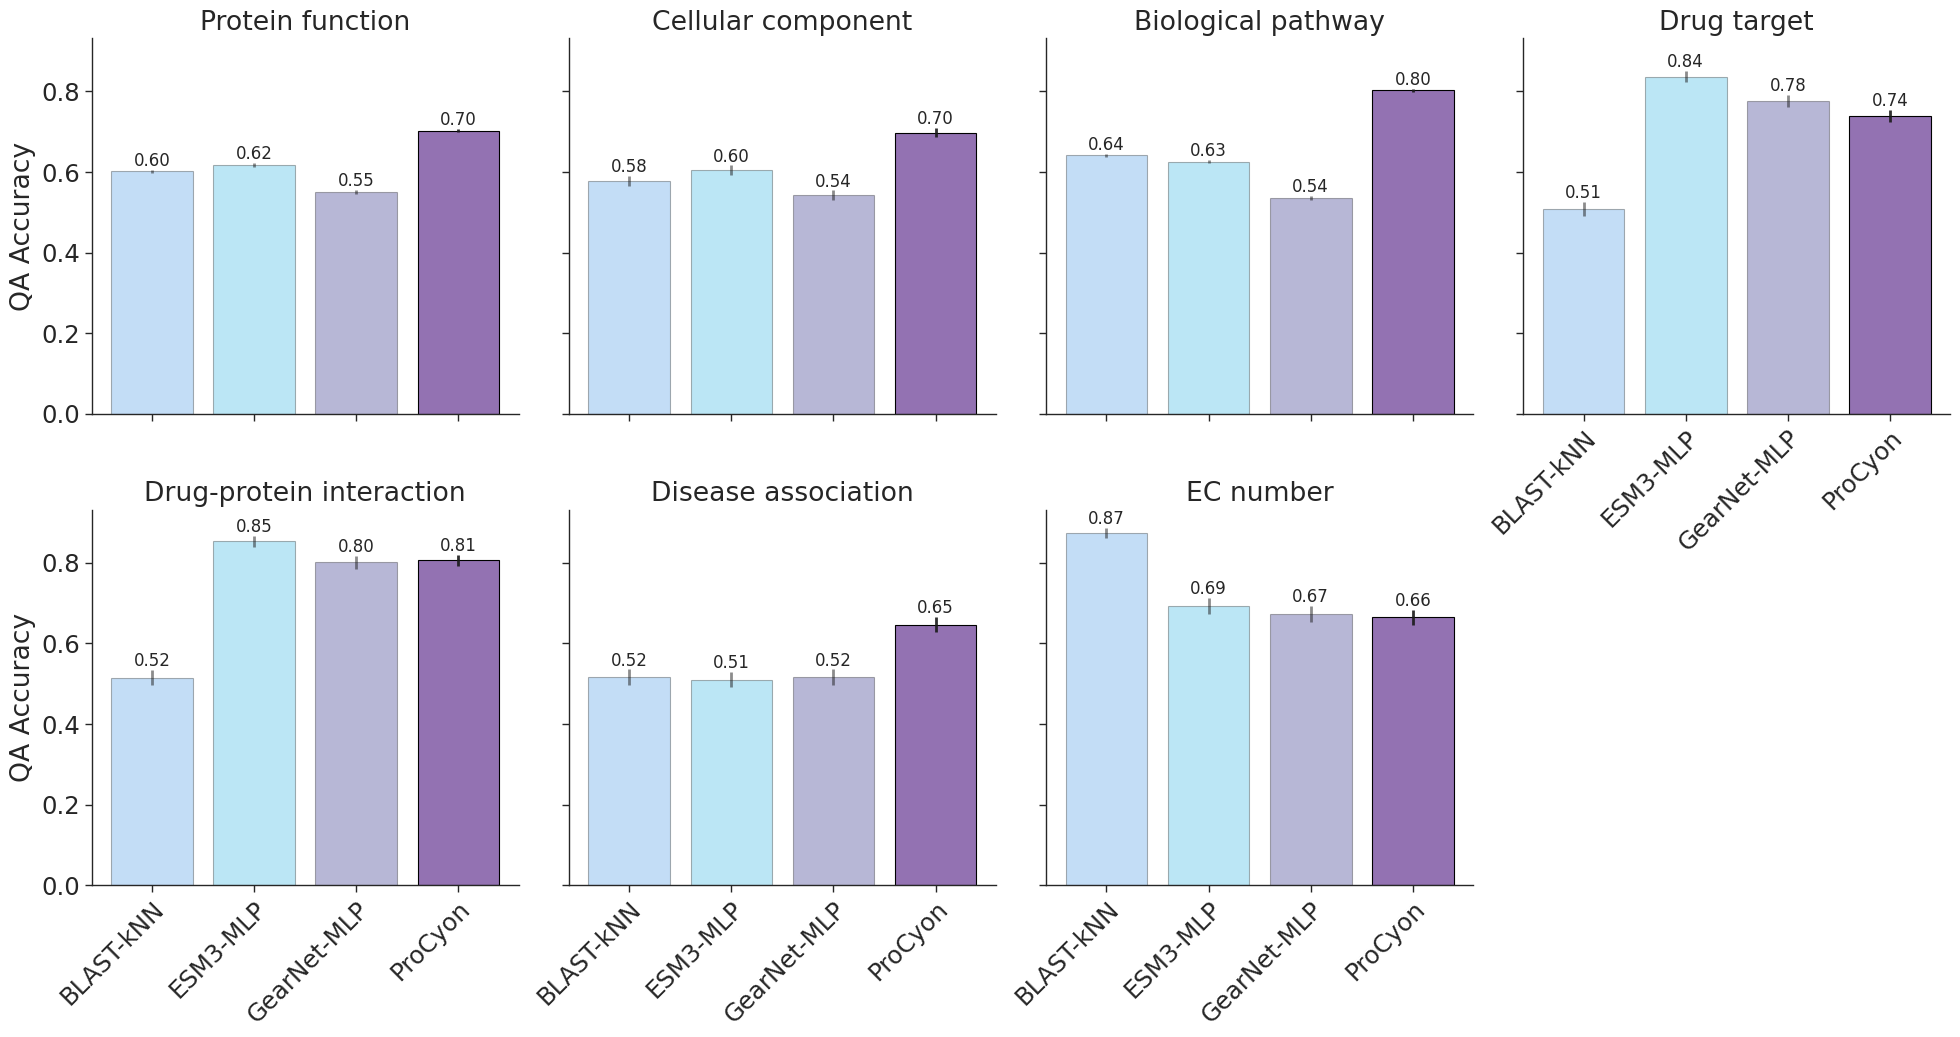

In [28]:
annotated_bar_plot(
    plot_data,
    model_order=model_order,
    metric="correct",
)

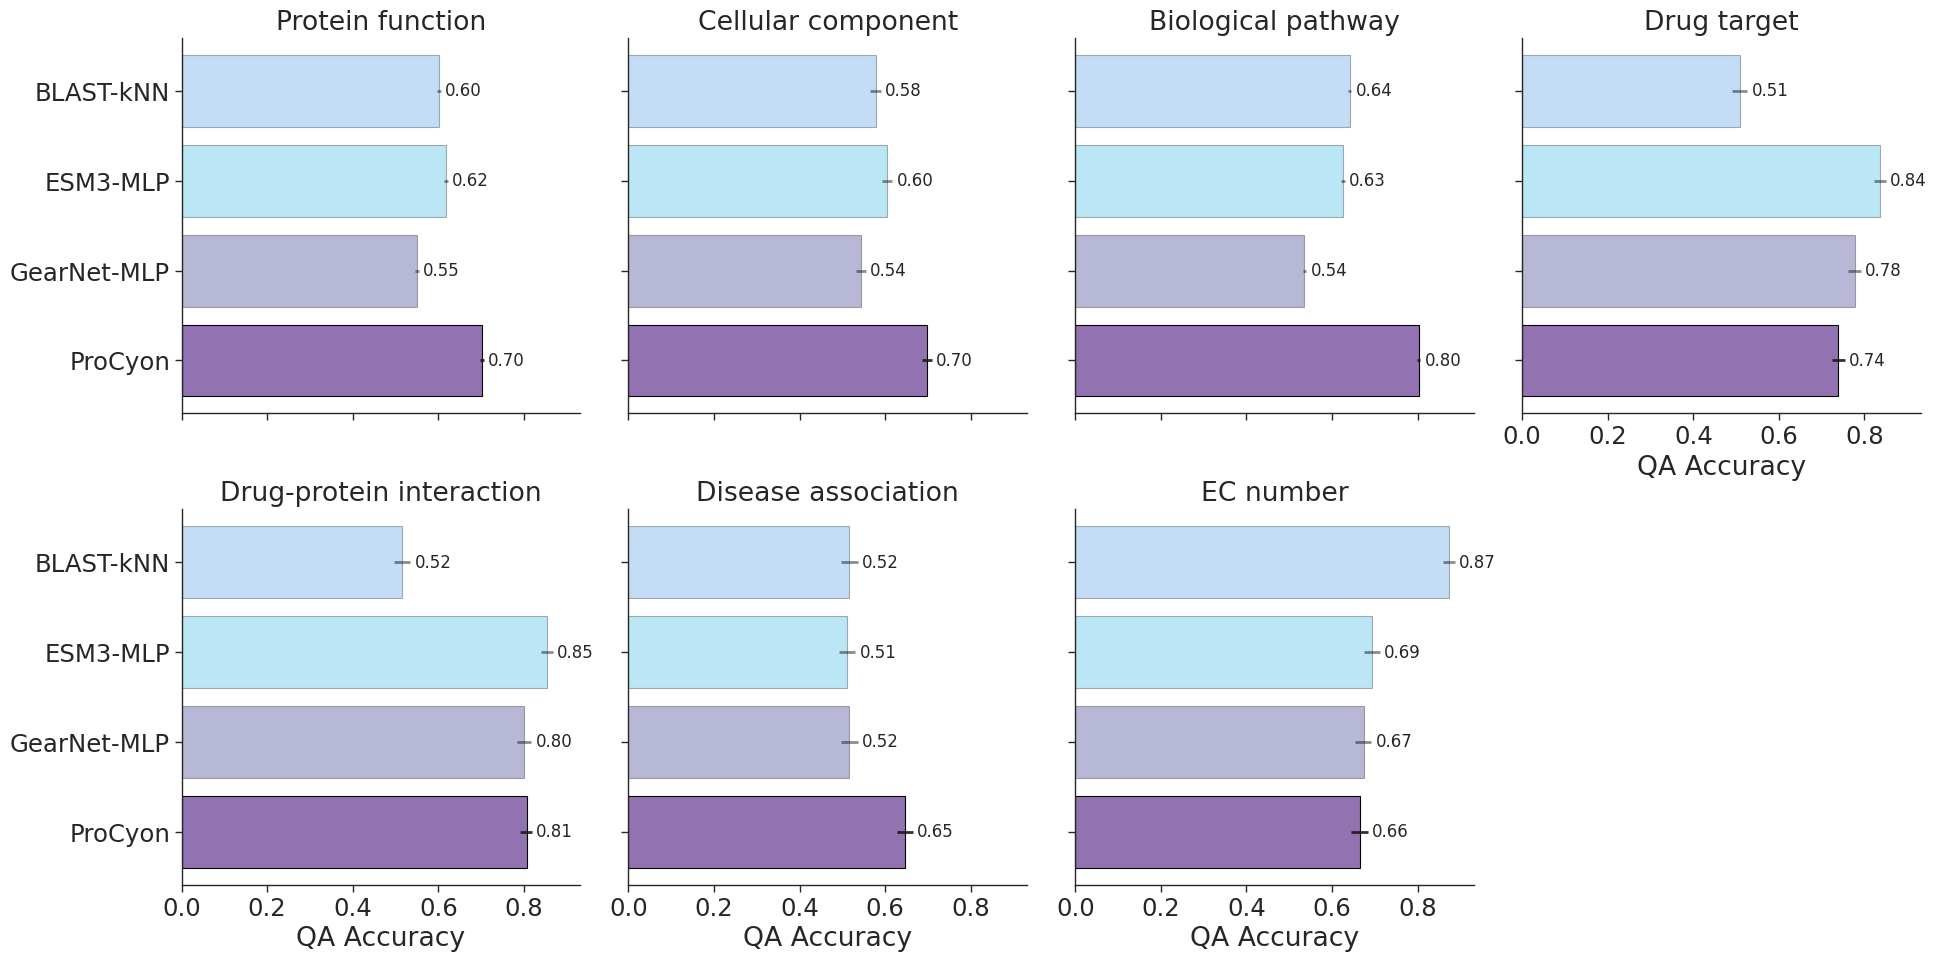

In [29]:
annotated_bar_plot_horizontal(
    plot_data,
    model_order=model_order,
    metric="correct",
)

# Extended data

## Full baseline set - retrieval

In [30]:
extended_models = {
    "UniformRandom": "UniformRandom",
    "BlastKnn": "BLAST-kNN",
    "ESMKnn": "ESM-kNN",
    "ESMMLP": "ESM-MLP",
    "ESM3Knn": "ESM3-kNN",
    "ESM3MLP": "ESM3-MLP",
    "GearNetKnn": "GearNet-kNN",
    "GearNetMLP": "GearNet-MLP",
    "BioTranslator": "BioTranslator",
    "ProtST": "ProtST",
    "ProCyon": "ProCyon",
}

extended_model_order = list(extended_models.values())

In [31]:
plot_data = (
    retrieval_data
    .loc[lambda x: x.model.isin(extended_models)]
    .assign(model=lambda x: x.model.map(extended_models))
    .reset_index(drop=True)
)
plot_data.head()

,query_id,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,auprc,dataset_relation,dataset,orig_split,orig_plot_split,plot_split,plot_task,model
0,0,0.30,0.750000,0.170000,0.85,0.090909,1.0,0.732857,0.881875,0.652682,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
1,1,0.20,1.000000,0.100000,1.00,0.090909,1.0,1.000000,1.000000,1.000000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
2,5,0.20,1.000000,0.100000,1.00,0.090909,1.0,0.603175,0.887500,0.512143,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
3,8,0.22,0.733333,0.150000,1.00,0.090909,1.0,0.667619,0.881111,0.577133,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
4,9,0.10,1.000000,0.090909,1.00,0.090909,1.0,0.866667,0.970000,0.800000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon


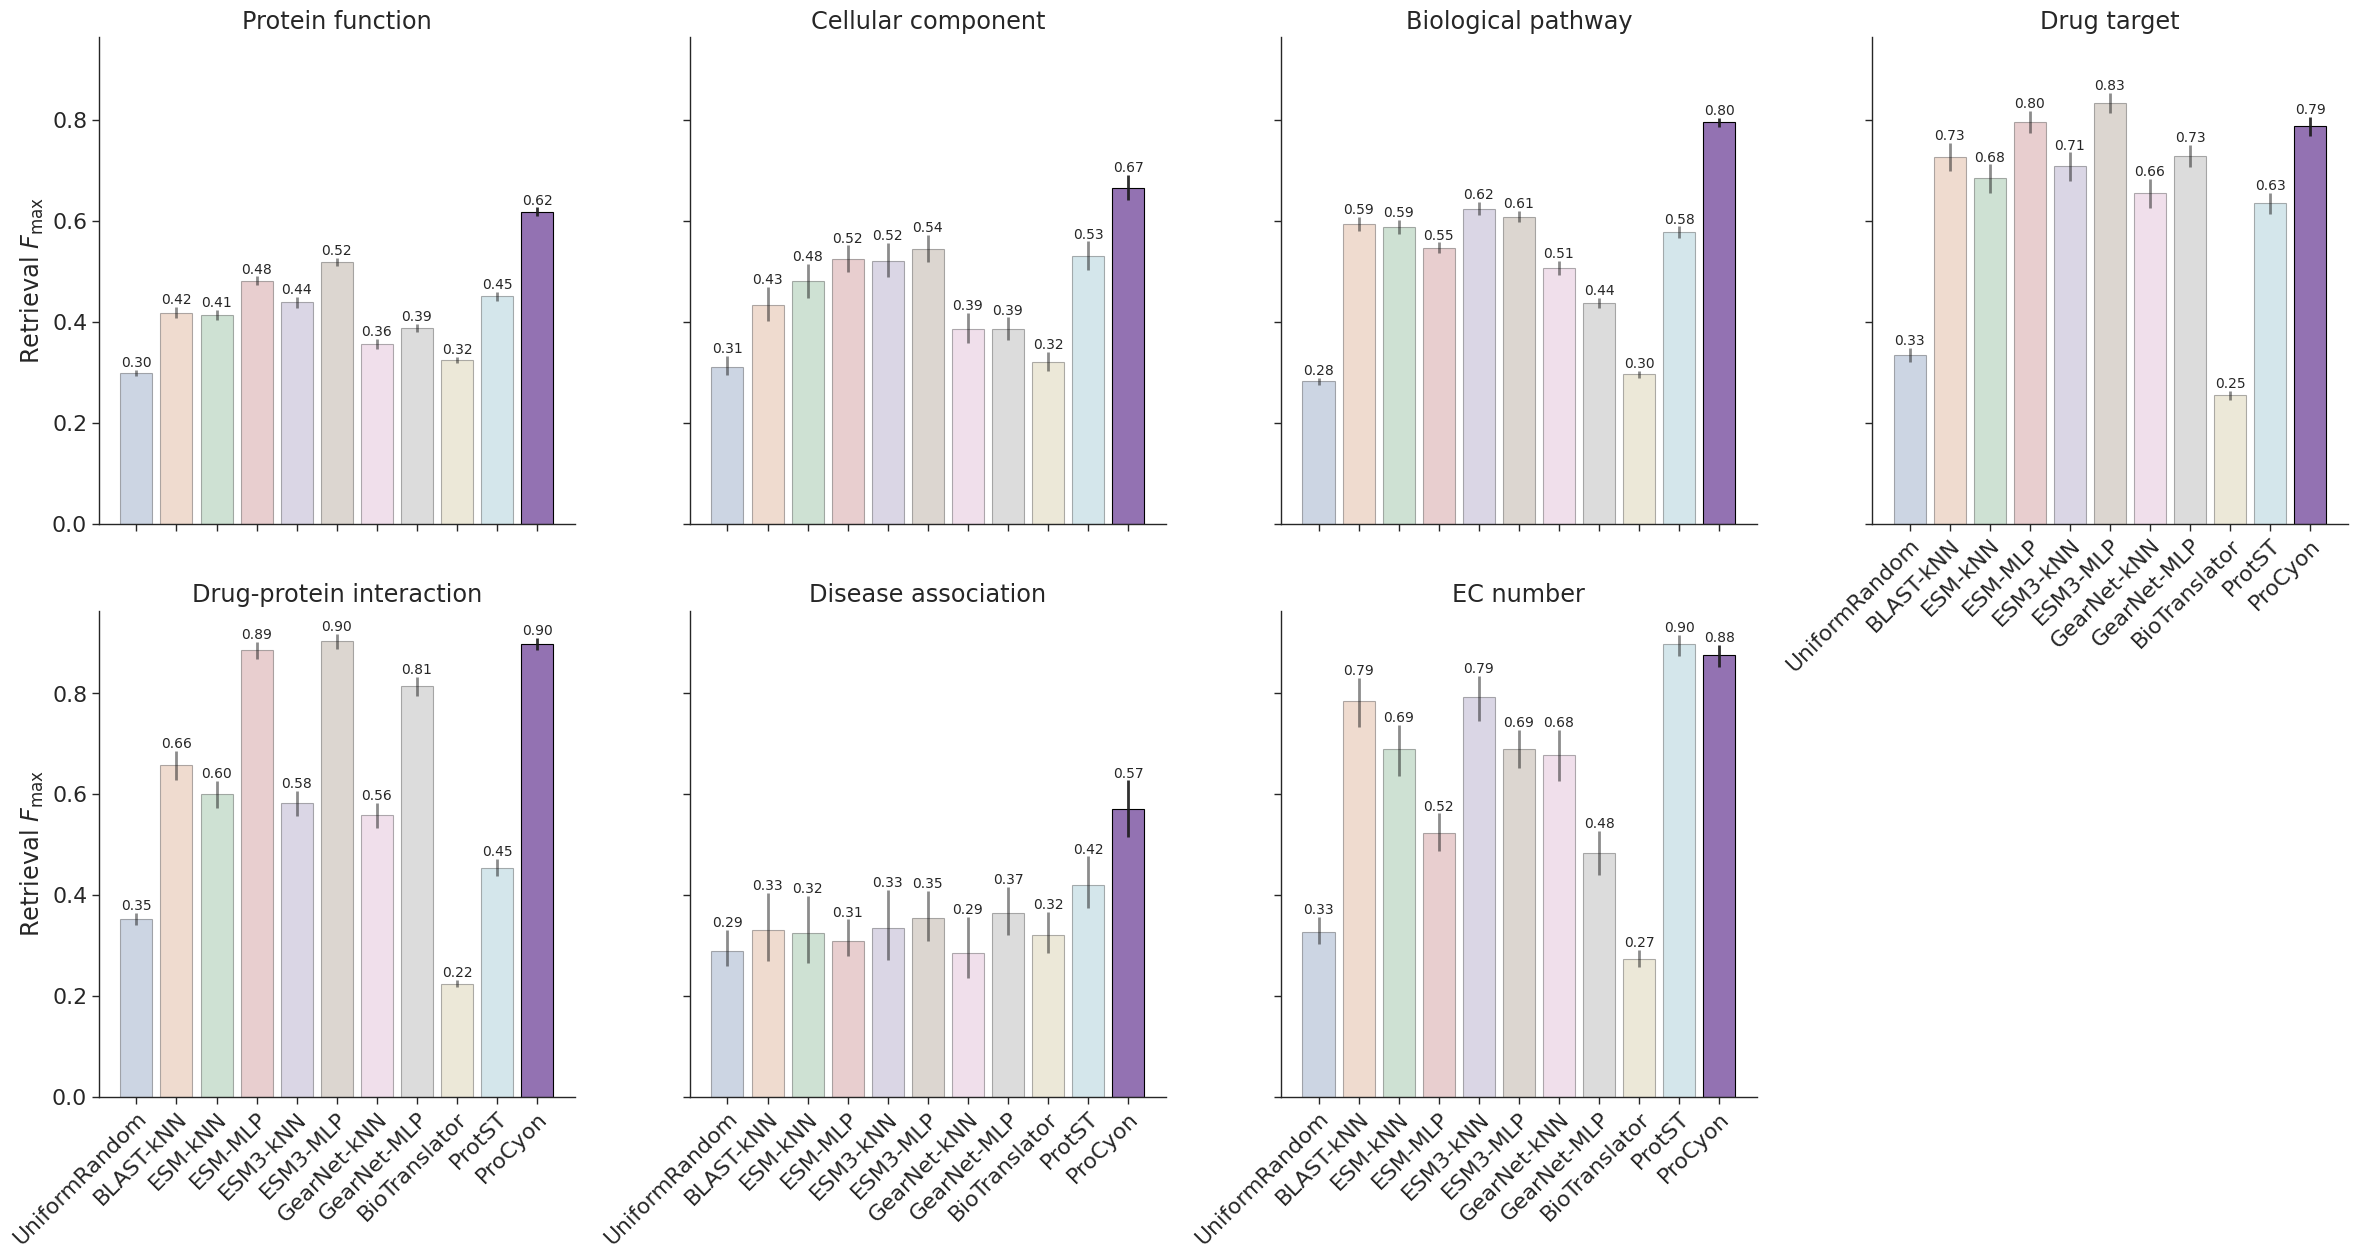

In [32]:
annotated_bar_plot(
    plot_data,
    model_order=extended_model_order,
    metric="Fmax",
    static_colors=False,
    textsize=10,
    height=6,
    fontscale=1.8
)

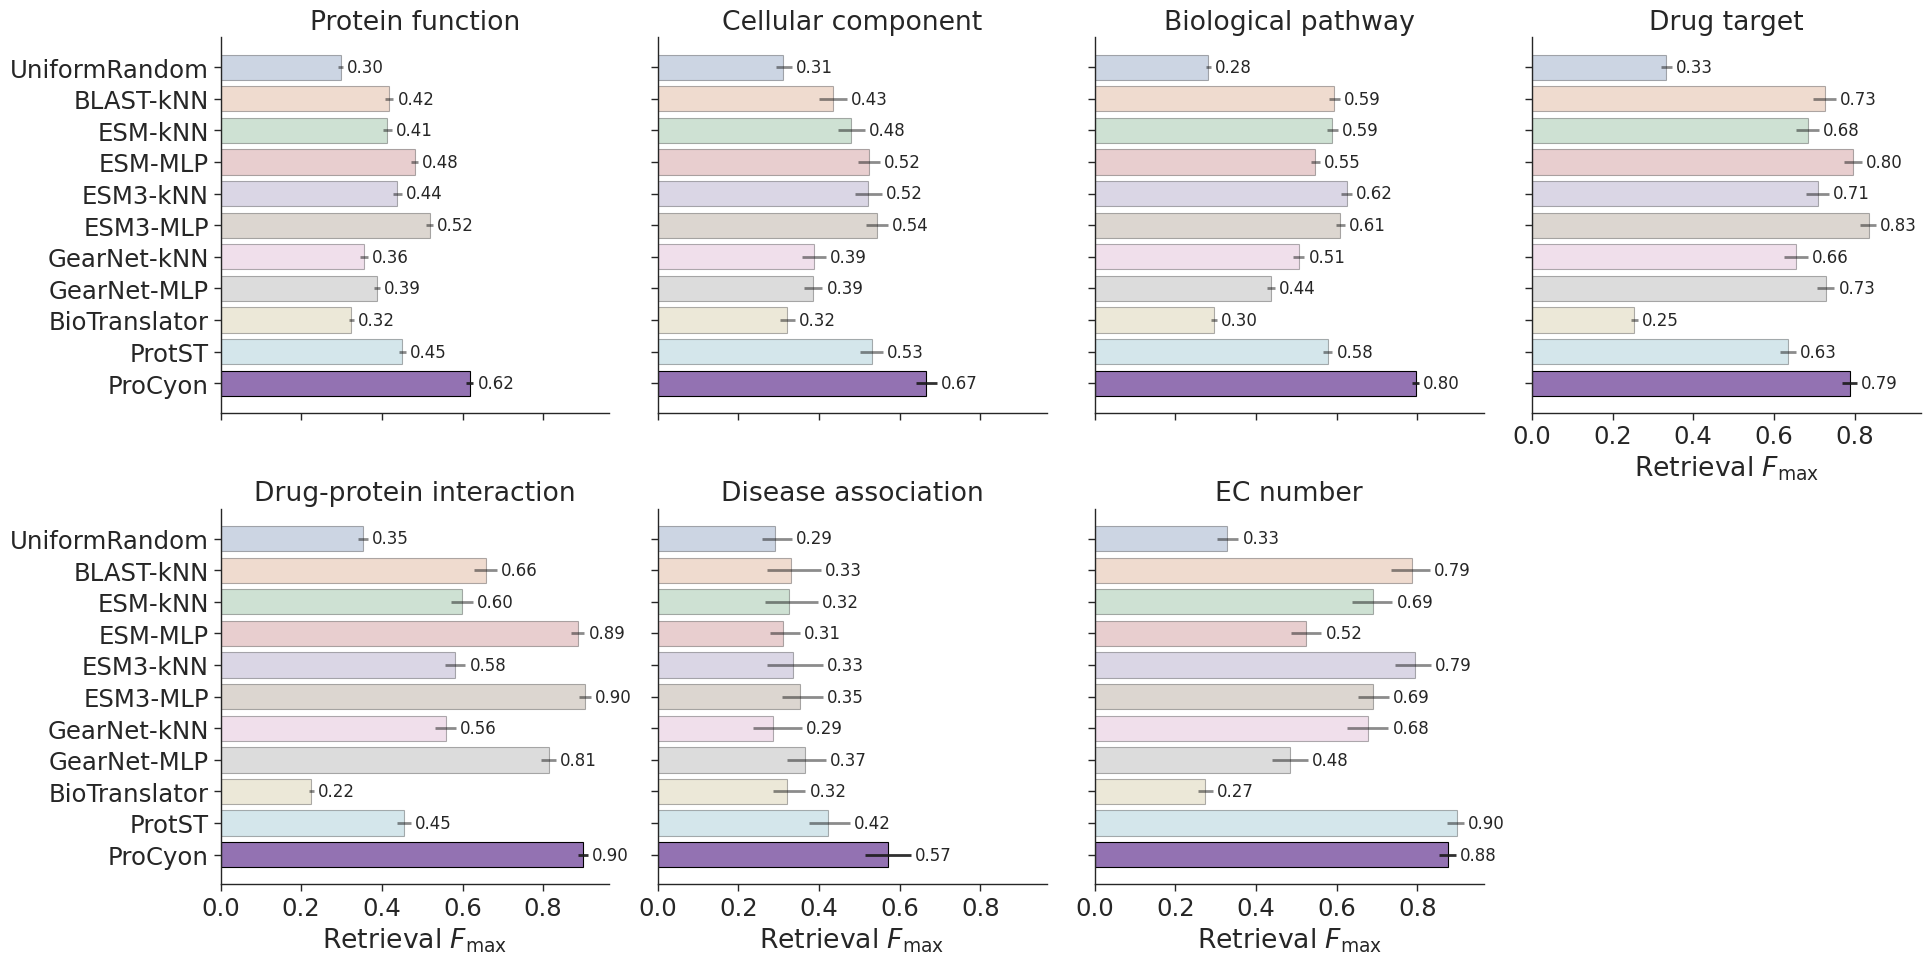

In [33]:
annotated_bar_plot_horizontal(
    plot_data,
    model_order=extended_model_order,
    metric="Fmax",
    static_colors=False,
)

## Full baseline set - QA

In [34]:
extended_models = {
    "BlastKnn": "BLAST-kNN",
    "ESMKnn": "ESM-kNN",
    "ESMMLP": "ESM-MLP",
    "ESM3Knn": "ESM3-kNN",
    "ESM3MLP": "ESM3-MLP",
    "GearNetKnn": "GearNet-kNN",
    "GearNetMLP": "GearNet-MLP",
    # TODO: add back in once we've regenerated results
    #"ProtLLM" : "ProtLLM"
    "ProCyon": "ProCyon",
}

extended_model_order = list(extended_models.values())

In [35]:
# We need different split maps here since most of the baselines
# can't handle the zero-shot phenotypes that we're treating as few-shot now.
qa_data = (
    qa_benchmark_results
    .loc[lambda x: ~x.orig_split.isin(["zero_shot_easy", "zero_shot"])]
    .loc[lambda x: (x.plot_split != "zero_shot") | (x.model == zero_shot_name)]
)
qa_data.model.value_counts()


model
ProCyon                115636
BlastKnn               114546
ESM3Knn                114546
ESM3MLP                114546
ESMKnn                 114546
ESMMLP                 114546
GearNetKnn             114546
GearNetMLP             114546
ProCyon (zero shot)     16460
Name: count, dtype: int64

In [36]:
plot_data = (
    qa_data
    .loc[lambda x: x.model.isin(extended_models)]
    .assign(model=lambda x: x.model.map(extended_models))
    .reset_index(drop=True)
)
plot_data.head()

,correct,dataset_relation,dataset,orig_split,orig_plot_split,plot_split,plot_task,model
0,True,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
1,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
2,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
3,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
4,True,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon


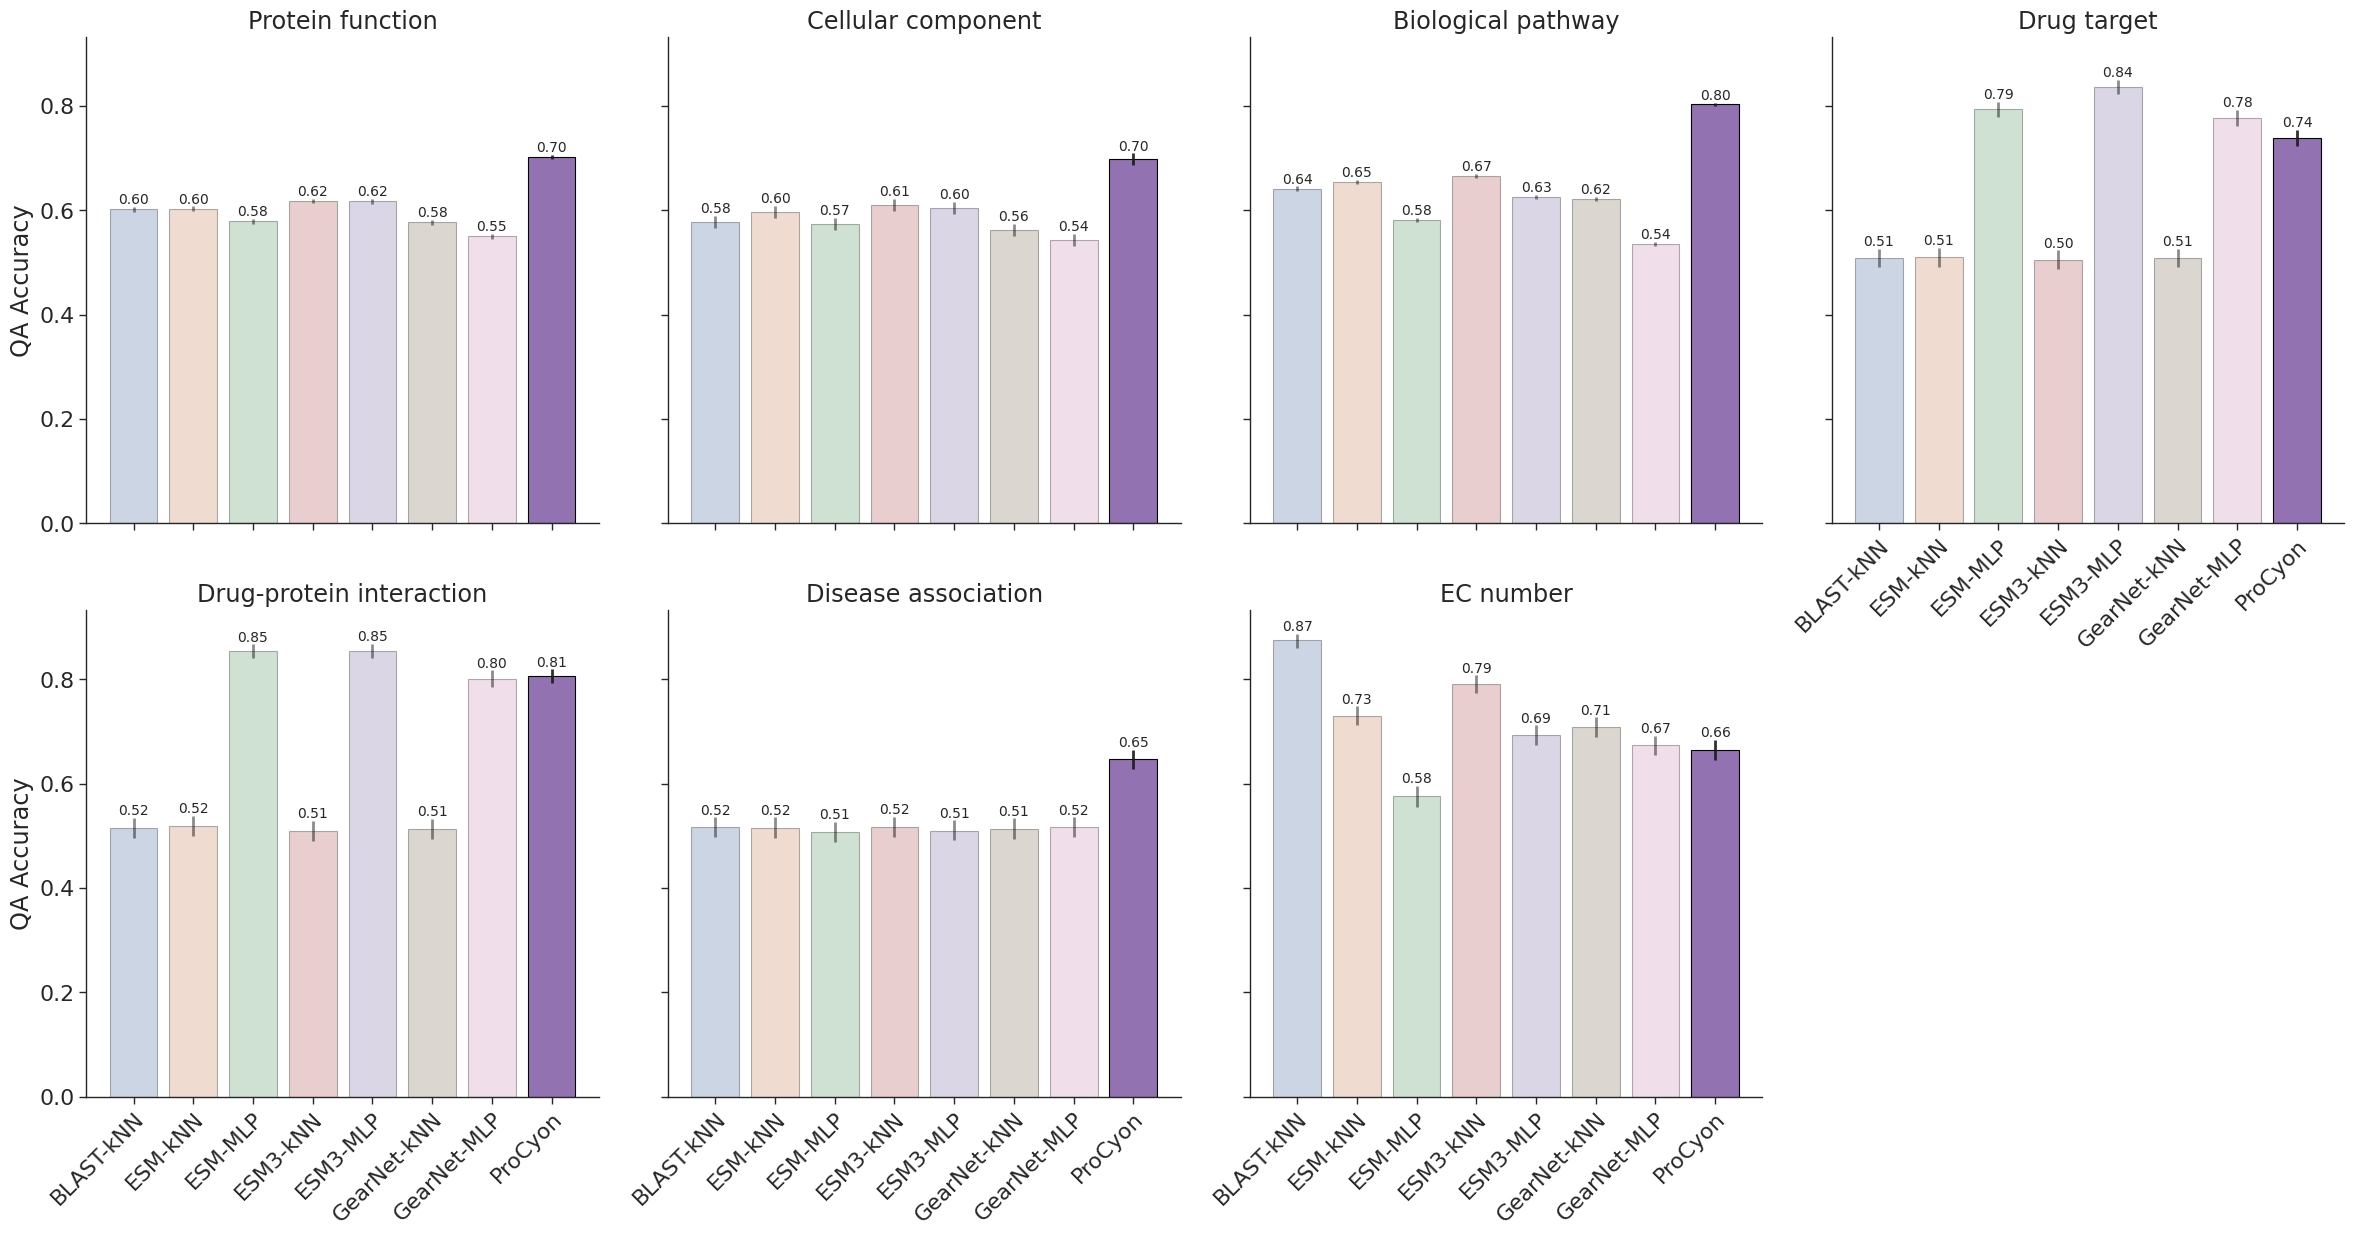

In [37]:
annotated_bar_plot(
    plot_data,
    model_order=extended_model_order,
    metric="correct",
    static_colors=False,
    textsize=10,
    height=6,
    fontscale=1.8
)

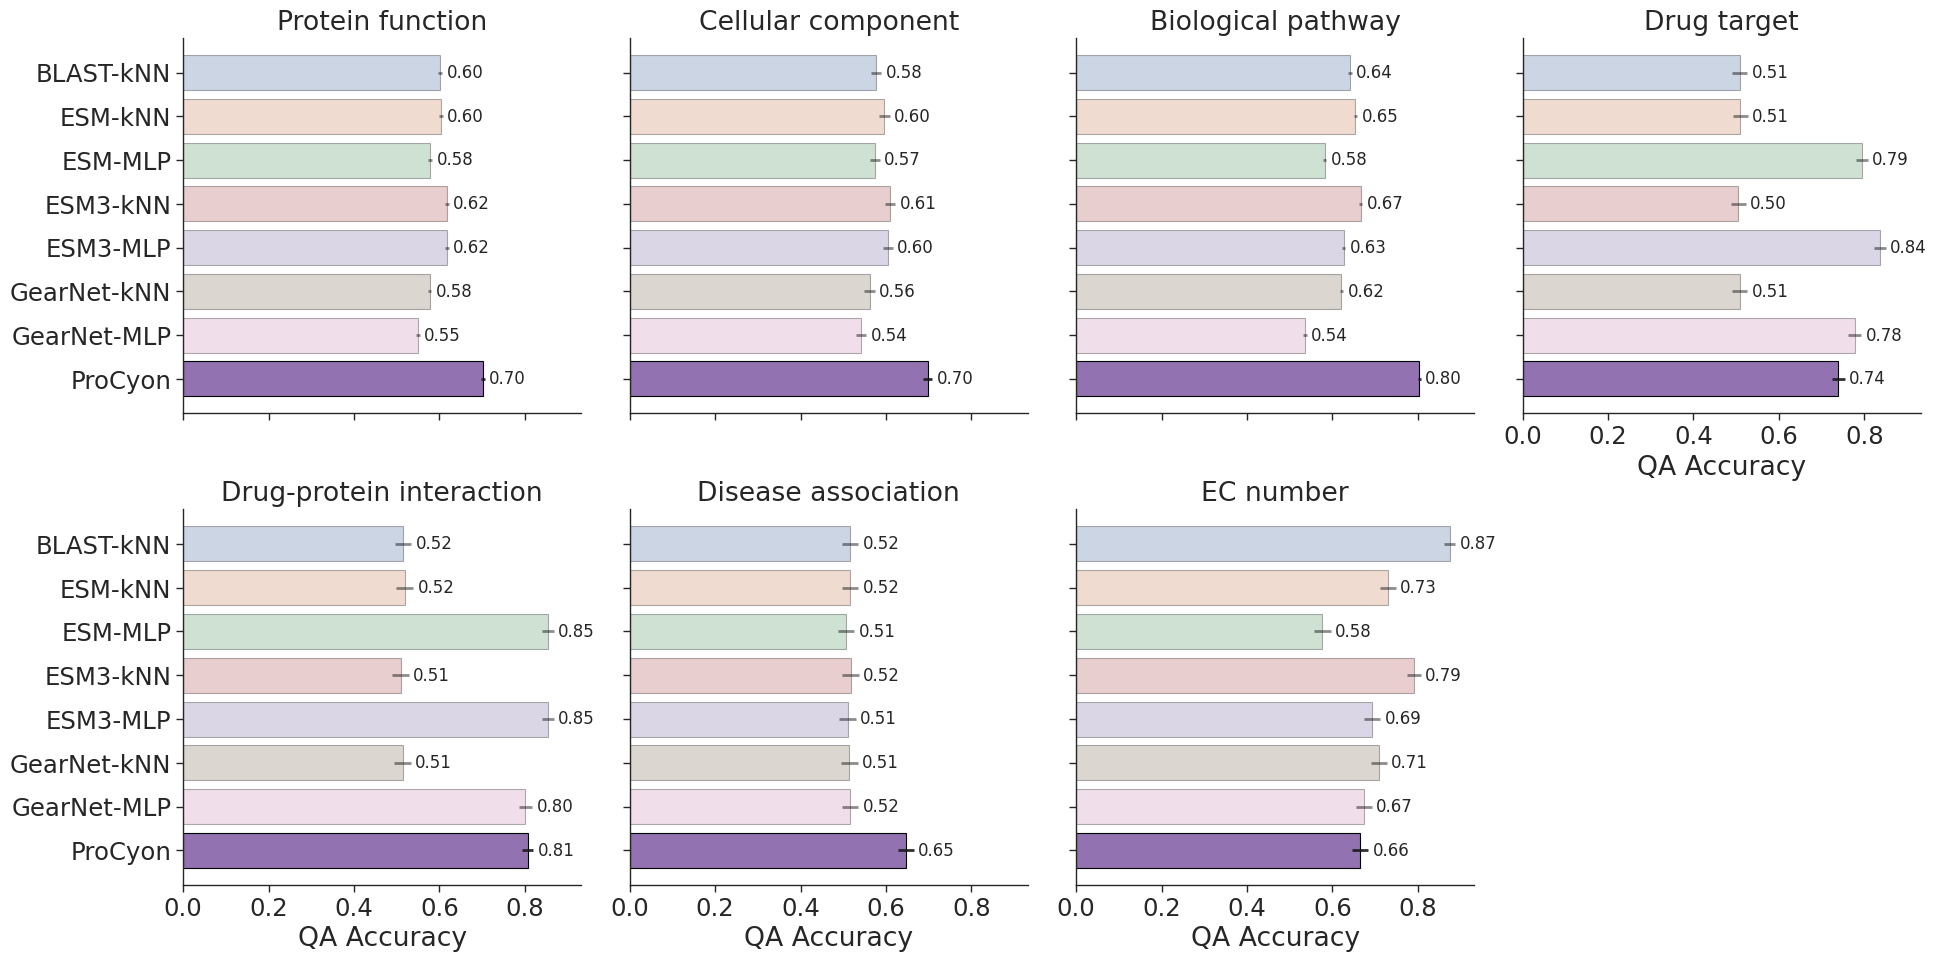

In [38]:
annotated_bar_plot_horizontal(
    plot_data,
    model_order=extended_model_order,
    metric="correct",
    static_colors=False,
)

## Performance across splits - retrieval

In [39]:
def across_split_perf_plot(
    data: pd.DataFrame,
    metric: str,
    model_order: List[str],
):
    fg = sns.FacetGrid(
        data=data,
        row="plot_task",
        col="plot_split",
        margin_titles=False,
        col_order=split_order,
    )

    fg.map_dataframe(
        sns.barplot,
        x="model",
        hue="model",
        palette=model_colors,
        y=metric,
        order=model_order,
        edgecolor="black",
        errorbar=None,
    )
    # Set column titles only for the first row
    for col_idx, col_name in enumerate(fg.col_names):
        fg.axes[0, col_idx].set_title(f"{col_name} splits", fontsize=16, y=1.15, fontweight="normal")

    # Remove column titles for all other rows
    for i in range(1, len(fg.row_names)):
        for j in range(len(fg.col_names)):
            fg.axes[i, j].set_title("")

    fg.set_xlabels("")
    if metric == "Fmax":
        ylabel = "Retrieval $F_{\max}$"
    elif metric == "correct":
        ylabel = "QA Accuracy"
    else:
        ylabel = metric
    fg.set_ylabels(ylabel)

    # Add subtitles for each row
    for i, row_val in enumerate(fg.row_names):
        # Get middle axis for this row
        ax = fg.axes[i, 1]
        ax.annotate(
            row_val,
            xy=(0.5, 1.05),
            xycoords="axes fraction",
            ha="center",
            va="bottom",
            fontsize=14,
            fontweight="normal"
        )

    bottom_row_idx = len(fg.row_names) - 1
    for ax in fg.axes[bottom_row_idx, :]:
        for label in ax.get_xticklabels():
            label.set(rotation=45, rotation_mode="anchor", ha="right")

    for (task, split), ax in fg.axes_dict.items():
        rects = [x[0] for x in ax.containers]
        rects = sorted(rects, key=lambda x: x.get_x())

        x_coords = []
        y_coords = []
        yerr = []
        for rect, model in zip(rects, model_order):
            want_df = plot_data.query("plot_split == @split and plot_task == @task and model == @model")
            err_lb, err_ub = calc_error_bounds(want_df[metric].values)

            xval = rect.get_center()[0]
            yval = rect.get_height()

            x_coords.append(xval)
            y_coords.append(yval)
            yerr.append(np.abs((err_lb - yval, err_ub - yval)))

            # Add text above the bar
            ax.text(
                x=xval,
                y=err_ub,
                s=f"{yval:.2f}",
                ha="center",
                va="bottom",
                fontsize=12,
            )
            if our_model_name not in model:
                rect.set(alpha=0.3)

        yerr = np.array(yerr).T
        ax.errorbar(
            x=x_coords,
            y=y_coords,
            yerr=yerr,
            fmt="none",
            c="k",
            alpha=0.8,
            elinewidth=2,
        )


In [40]:
zero_shot_models = [
    "BioTranslator",
    "ProtST",
    our_model_name,
]

plot_data = (
    all_results
    .loc[lambda x: x.model.isin(zero_shot_models)]
    .drop(columns=["orig_split", "orig_plot_split"])
    .assign(
        plot_split=lambda x: x.plot_split.map(split_rename),
    )
)
plot_data.head()

,query_id,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,auprc,dataset_relation,dataset,plot_split,plot_task,model
0,0,0.30,0.750000,0.170000,0.85,0.090909,1.0,0.732857,0.881875,0.652682,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
1,1,0.20,1.000000,0.100000,1.00,0.090909,1.0,1.000000,1.000000,1.000000,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
2,5,0.20,1.000000,0.100000,1.00,0.090909,1.0,0.603175,0.887500,0.512143,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
3,8,0.22,0.733333,0.150000,1.00,0.090909,1.0,0.667619,0.881111,0.577133,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
4,9,0.10,1.000000,0.090909,1.00,0.090909,1.0,0.866667,0.970000,0.800000,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon


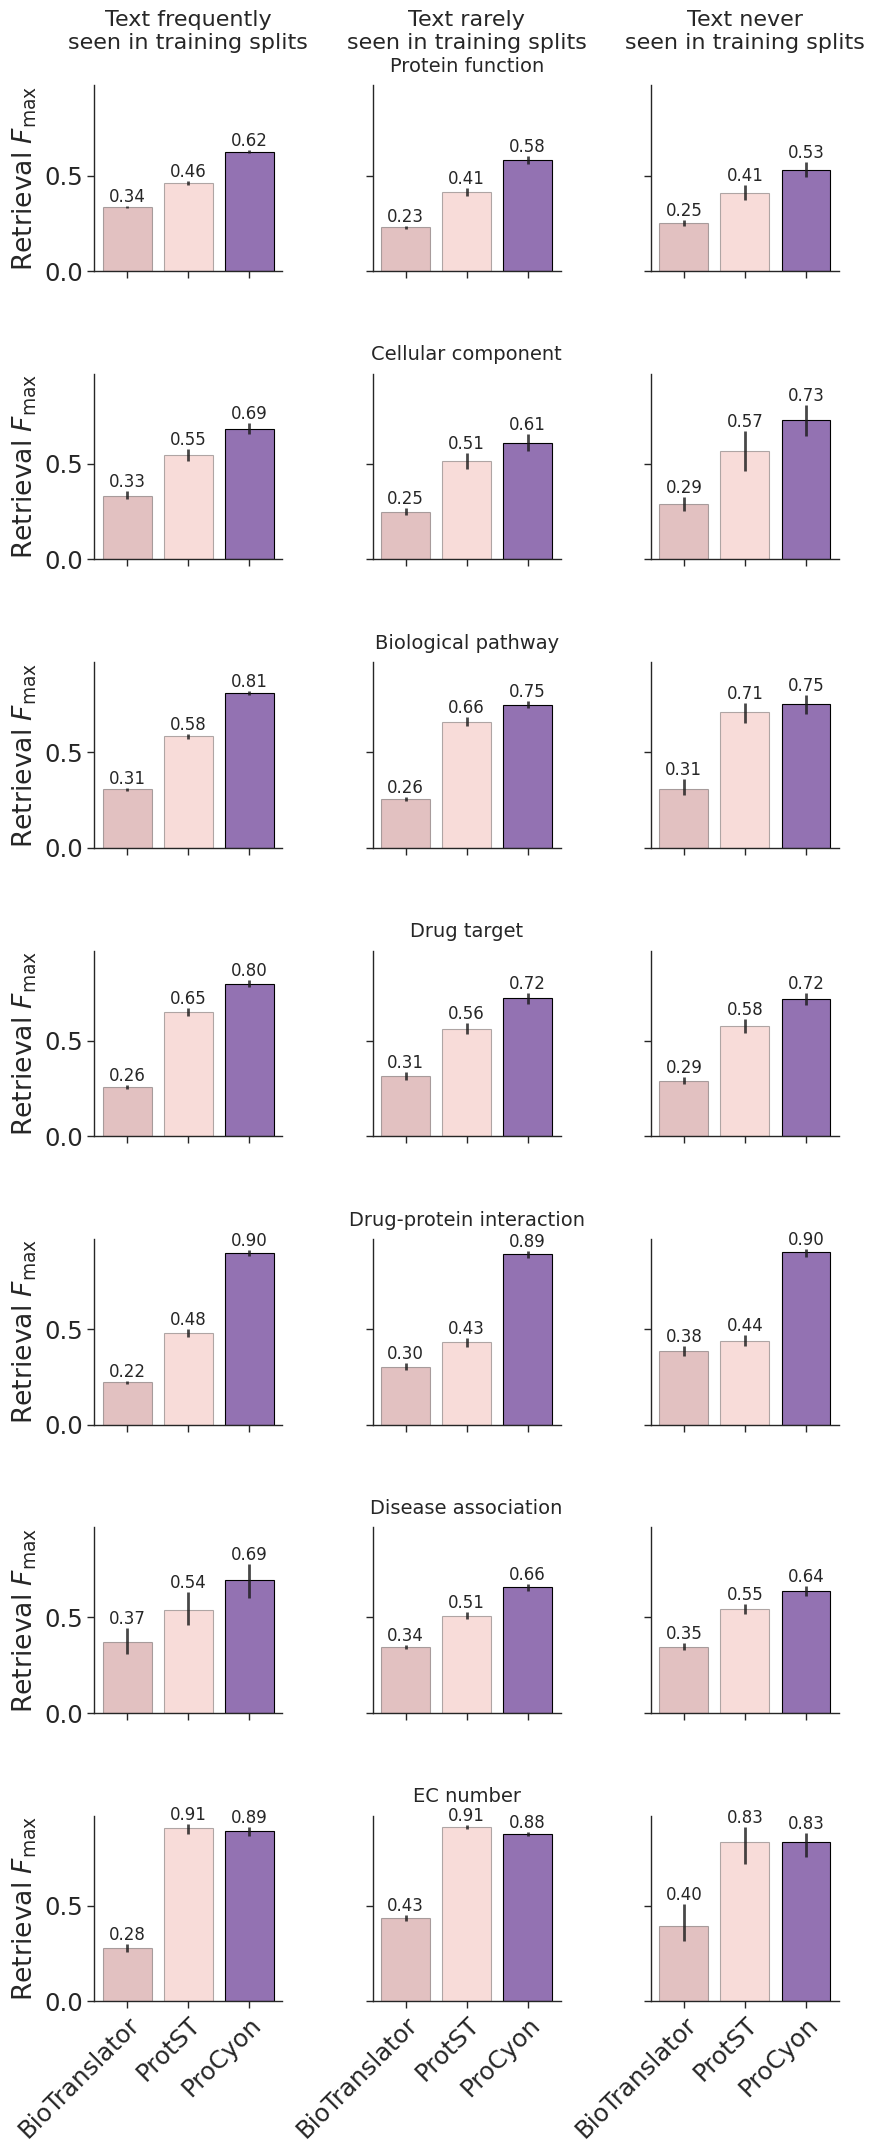

In [41]:
across_split_perf_plot(
    plot_data,
    metric="Fmax",
    model_order=zero_shot_models,
)

### ProCyon only

In [96]:
plot_data = (
    all_results
    .loc[lambda x: x.model == our_model_name]
    .drop(columns=["orig_split", "orig_plot_split"])
    .assign(
        plot_split=lambda x: x.plot_split.map(split_rename),
    )
)
plot_data.head()

,query_id,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,auprc,dataset_relation,dataset,plot_split,plot_task,model
0,0,0.30,0.750000,0.170000,0.85,0.090909,1.0,0.732857,0.881875,0.652682,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
1,1,0.20,1.000000,0.100000,1.00,0.090909,1.0,1.000000,1.000000,1.000000,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
2,5,0.20,1.000000,0.100000,1.00,0.090909,1.0,0.603175,0.887500,0.512143,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
3,8,0.22,0.733333,0.150000,1.00,0.090909,1.0,0.667619,0.881111,0.577133,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
4,9,0.10,1.000000,0.090909,1.00,0.090909,1.0,0.866667,0.970000,0.800000,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon


In [75]:
split_palette = {
    split: to_rgba(procyon_color) for split in split_order
}
split_palette

{'Text frequently\nseen in training': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353,
  1.0),
 'Text rarely\nseen in training': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353,
  1.0),
 'Text never\nseen in training': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353,
  1.0)}

In [99]:
alphas = [0.3, 0.5, 1]
alpha_map = {
    split: alpha for split, alpha in zip(split_order, alphas)
}

(0.0, 1.0)

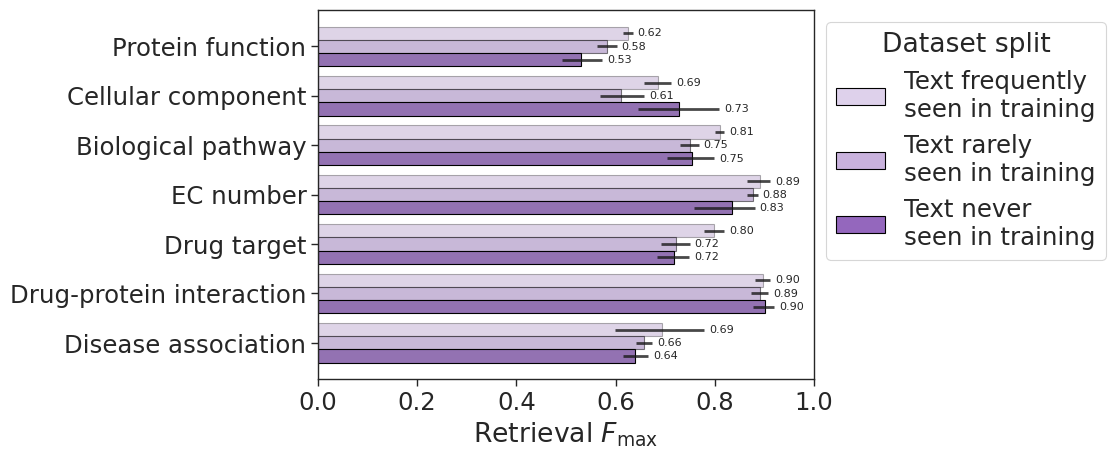

In [100]:
fontscale = 2
height = 6
metric = "Fmax"
textsize = 8

sns.set_theme(context="paper", style="ticks", font_scale=fontscale)
sns.set_style("ticks")
ax = sns.barplot(
    x=metric,
    y="plot_task",
    order=task_order,
    edgecolor="black",
    hue="plot_split",
    palette=split_palette,
    data=plot_data,
    errorbar=None,
)

if metric == "Fmax":
    xlabel = "Retrieval $F_{\max}$"
elif metric == "correct":
    xlabel = "QA Accuracy"
else:
    xlabel = metric
ax.set_xlabel(xlabel)
ax.set_ylabel("")

rects = [x for cont in ax.containers for x in cont]
rects = sorted(rects, key=lambda x: x.get_y())

x_coords = []
y_coords = []
yerr = []

procyon_x_coords = []
procyon_y_coords = []
procyon_yerr = []
for i, rect in enumerate(rects):
    task = task_order[i // len(split_order)]
    split = split_order[i % len(split_order)]
    want_df = plot_data.query("plot_task == @task and plot_split == @split")
    err_lb, err_ub = calc_error_bounds(want_df[metric].values)

    yval = rect.get_center()[1]
    xval = rect.get_width()

    alpha = alpha_map[split]
    rect.set(alpha=alpha)

    x_coords.append(xval)
    y_coords.append(yval)
    yerr.append(np.abs((err_lb - xval, err_ub - xval)))

    # Add text to right of the bar
    ax.text(
        x=err_ub + 0.01,
        y=yval,
        s=f"{xval:.2f}",
        ha="left",
        va="center",
        fontsize=textsize,
    )

yerr = np.array(yerr).T
ax.errorbar(
    x=x_coords,
    y=y_coords,
    xerr=yerr,
    fmt="none",
    c="k",
    alpha=0.8,
    elinewidth=2,
)

patches = []
for split, alpha in alpha_map.items():
    patch = mpatches.Patch(facecolor=to_rgba(procyon_color, alpha), label=split, edgecolor="black")
    patches.append(patch)
ax.legend(title="Dataset split", handles=patches, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(0, 1.0)


## Performance across splits - QA

In [15]:
zero_shot_models = [
    #"ProtLLM",
    our_model_name,
]

plot_data = (
    all_qa_results
    .loc[lambda x: x.model.isin(zero_shot_models)]
    .drop(columns=["orig_split", "orig_plot_split"])
    .assign(
        plot_split=lambda x: x.plot_split.map(split_rename),
    )
)
plot_data.head()

,correct,dataset_relation,dataset,plot_split,plot_task,model
0,True,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
1,False,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
2,False,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
3,False,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
4,True,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon


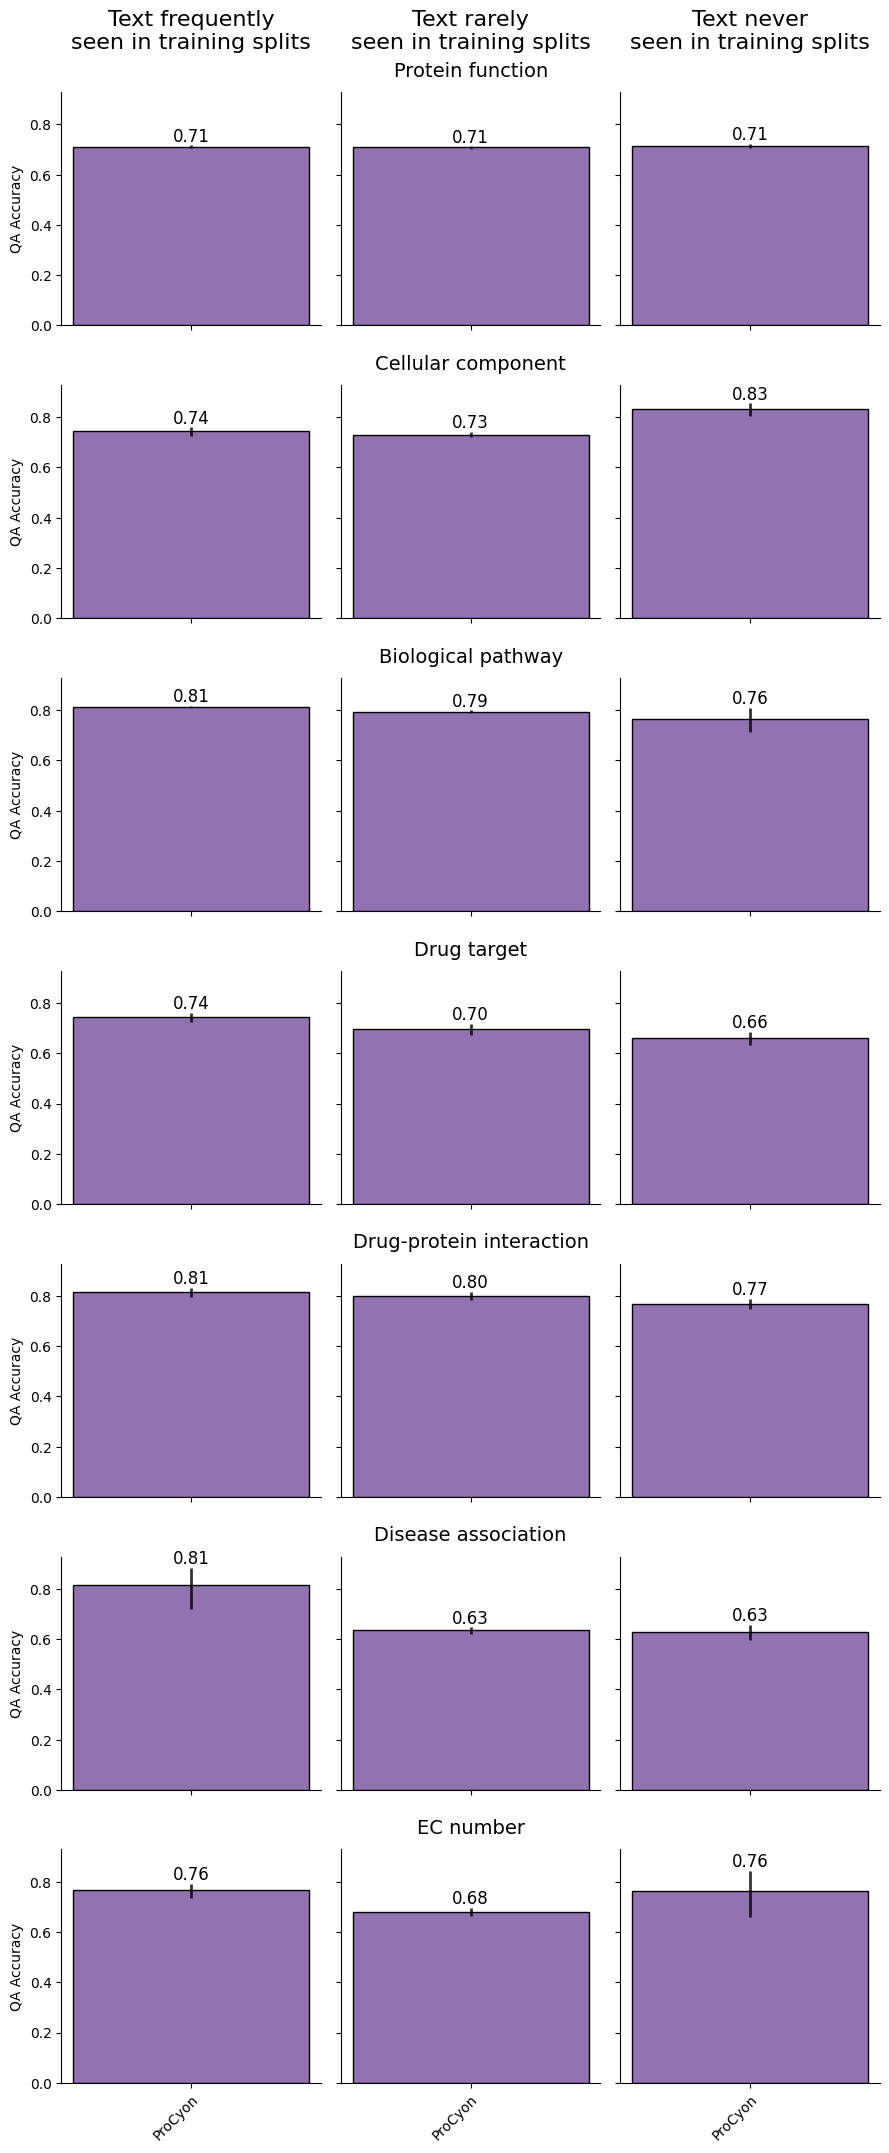

In [16]:
across_split_perf_plot(
    plot_data,
    metric="correct",
    model_order=zero_shot_models,
)

### ProCyon only

In [91]:
plot_data = (
    all_qa_results
    .loc[lambda x: x.model == our_model_name]
    .drop(columns=["orig_split", "orig_plot_split"])
    .assign(
        plot_split=lambda x: x.plot_split.map(split_rename),
    )
)
plot_data.head()

,correct,dataset_relation,dataset,plot_split,plot_task,model
0,True,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
1,False,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
2,False,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
3,False,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
4,True,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon


(0.0, 1.0)

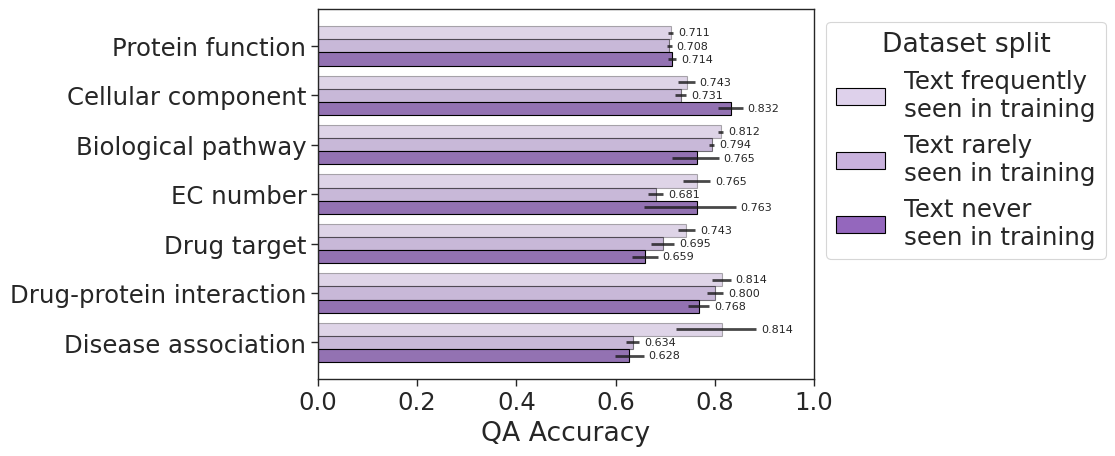

In [95]:
fontscale = 2
height = 6
metric = "correct"
textsize = 8

sns.set_theme(context="paper", style="ticks", font_scale=fontscale)
sns.set_style("ticks")
ax = sns.barplot(
    x=metric,
    y="plot_task",
    order=task_order,
    edgecolor="black",
    hue="plot_split",
    palette=split_palette,
    data=plot_data,
    errorbar=None,
)

if metric == "Fmax":
    xlabel = "Retrieval $F_{\max}$"
elif metric == "correct":
    xlabel = "QA Accuracy"
else:
    xlabel = metric
ax.set_xlabel(xlabel)
ax.set_ylabel("")

rects = [x for cont in ax.containers for x in cont]
rects = sorted(rects, key=lambda x: x.get_y())

x_coords = []
y_coords = []
yerr = []

procyon_x_coords = []
procyon_y_coords = []
procyon_yerr = []
for i, rect in enumerate(rects):
    task = task_order[i // len(split_order)]
    split = split_order[i % len(split_order)]
    want_df = plot_data.query("plot_task == @task and plot_split == @split")
    err_lb, err_ub = calc_error_bounds(want_df[metric].values)

    yval = rect.get_center()[1]
    xval = rect.get_width()

    alpha = alpha_map[split]
    rect.set(alpha=alpha)

    x_coords.append(xval)
    y_coords.append(yval)
    yerr.append(np.abs((err_lb - xval, err_ub - xval)))

    # Add text to right of the bar
    ax.text(
        x=err_ub + 0.01,
        y=yval,
        s=f"{xval:.3f}",
        ha="left",
        va="center",
        fontsize=textsize,
    )

yerr = np.array(yerr).T
ax.errorbar(
    x=x_coords,
    y=y_coords,
    xerr=yerr,
    fmt="none",
    c="k",
    alpha=0.8,
    elinewidth=2,
)

patches = []
for split, alpha in alpha_map.items():
    patch = mpatches.Patch(facecolor=to_rgba(procyon_color, alpha), label=split, edgecolor="black")
    patches.append(patch)
ax.legend(title="Dataset split", handles=patches, loc="upper left", bbox_to_anchor=(1, 1))

ax.set_xlim(0, 1.0)
